- **Silhouette e DBCV tra -1 e 1**

- **CLustering truth e ARI con dati default**

- **Normalizzo nomi Mean_shift come "Meanshift" e HDBSCAN_DEFAULT con "HDBSCAN_default" per tutti**

- **nei plot incolonnare gli algoritmi HDBSCAN con HDBSCAN ecc...**

- **Mettere le scritte in obliquo**

- Tabella con From optimized methods to methods with default values:
CHI trend: freccia su / stabile / freccia giù
DBCV score: freccia su / stabile / freccia giù

- Controllare funzione ricerca parametri migliori DBCV

#**Library**

In [1]:
pip install "git+https://github.com/FelSiq/DBCV"


  Cloning https://github.com/FelSiq/DBCV to /tmp/pip-req-build-m12i8f4e
  Running command git clone --filter=blob:none --quiet https://github.com/FelSiq/DBCV /tmp/pip-req-build-m12i8f4e
  Resolved https://github.com/FelSiq/DBCV to commit 13c3896ef78d12f1e3e1cbd394f2db9a09637ffd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dbcv: filename=dbcv-0.1.1-py3-none-any.whl size=6619 sha256=70d0c9143313437cb9d0bbc8e1a0645a4ca1db978989086a811cce0b7019599d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2nu7cvyy/wheels/db/29/5c/22f8798fd788b7f37312b81a63fab3aa43bea8270f453fbe8c
Successfully built dbcv


In [2]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import hdbscan
from hdbscan import HDBSCAN
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from dbcv import dbcv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score,adjusted_rand_score , davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from scipy.stats import entropy
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.utils import resample
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.special import erf
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



#**Function**

In [4]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarray of shape (n_samples, n_features)
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs = 3
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = []

    for gap_index, k in enumerate(range(1, maxClusters)):

        refDisps = np.zeros(nrefs)

        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(n_clusters=k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(n_clusters=k)
        km.fit(data)

        origDisp = km.inertia_

        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        gaps[gap_index] = gap
        results.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(results)
    return gaps.argmax() + 1, resultsdf

In [5]:
def generate_moon_datasets(seed):
    datasets = []

    for noise in [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]:
        X, _ = make_moons(n_samples=1000, noise=noise, random_state=seed)
        datasets.append(X)

    return datasets

In [6]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, dataset in enumerate(datasets):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.scatter(dataset[:, 0], dataset[:, 1], c='black', s=1)
        ax.set_title(f'Dataset {i+1}')
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1.0, 1.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_best_results_compare(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        print(dataset_results)
        for min_samples_, epsilon_, dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz,shannon_entropy, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}\nsilhouette={silhouette:.3f}\ndunn={dunn_index:.3f}\ndavies={davies_bouldin:.3f}\ncalinski={calinski_harabasz:.3f}\nshannon_entropy={shannon_entropy:.3f}')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
#Se non funziona usare funzione precedente
def calculate_dunn_index(X, labels):

    X = np.array(X) if not isinstance(X, np.ndarray) else X
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return -1

    distances = np.sqrt(((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=2))
    min_intercluster_distances = np.inf
    for label_i in unique_labels:
        cluster_i = X[labels == label_i]
        for label_j in unique_labels:
            if label_i != label_j:
                cluster_j = X[labels == label_j]
                intercluster_distances = np.min(distances[np.ix_(labels == label_i, labels == label_j)])
                min_intercluster_distances = min(min_intercluster_distances, intercluster_distances)
    max_intracluster_distances = 0
    for label in unique_labels:
        cluster = X[labels == label]
        intracluster_distances = np.max(distances[np.ix_(labels == label, labels == label)])
        max_intracluster_distances = max(max_intracluster_distances, intracluster_distances)
    return min_intercluster_distances / max_intracluster_distances



In [9]:
def analyze_datasets(datasets):
    results = []
    param_grid = {
        'min_samples': [10],
        'epsilon': [0.1]
    }

    for X in datasets:
        dataset_results = []
        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                #clusterer = hdbscan.HDBSCAN(min_samples = min_samples, cluster_selection_epsilon=epsilon)
                labels = clusterer.fit_predict(X)

                dbcv_score = dbcv(X, labels)
                silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
                dunn_index = calculate_dunn_index(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
                calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
                shannon_entropy = calculate_shannon_entropy(labels)
                dataset_results.append((min_samples, epsilon, dbcv_score, silhouette, dunn_index,
                                        davies_bouldin, calinski_harabasz, shannon_entropy, labels))

        results.append(dataset_results)

    return results

In [10]:
def analyze_datasets_best_params(datasets):
    results = []
    param_grid = {
        'min_samples': [1, 5, 10, 50],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }

    for X in datasets:
        dataset_results = []

        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                labels = clusterer.fit_predict(X)
                dbcv_score = dbcv(X, labels)
                dataset_results.append((min_samples, epsilon, dbcv_score,labels))

        results.append(dataset_results)

    return results

In [11]:
def find_best_params(results):
    param_dbvcs = {}

    for dataset_results in results:
        for min_samples, epsilon, dbcv_score, labels in dataset_results:
            param_key = (min_samples, epsilon)
            if param_key not in param_dbvcs:
                param_dbvcs[param_key] = []
            param_dbvcs[param_key].append(dbcv_score)

    param_avg_dbcv = {k: np.mean(v) for k, v in param_dbvcs.items()}

    best_params = max(param_avg_dbcv, key=param_avg_dbcv.get)

    return best_params

In [12]:
import matplotlib.pyplot as plt

def plot_best_results(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params
    min_samples = 2
    epsilon = 0.1

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        for min_samples_, epsilon_, dbcv_score, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                if dbcv_score is not None:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}')
                else:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv=N/A')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
def calculate_shannon_entropy(labels):
    labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    # labels = labels + 1
    # entropy_val = entropy(np.bincount(labels) / len(labels), base=2)
    # entropy_val = abs(1-entropy_val)
    return entropy

In [14]:
def plot_datasets_with_clustering(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = dataset

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-1.5, 2.5)
        ax_left.set_ylim(-1.0, 1.5)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(min_samples=10, eps=0.1)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-1.5, 2.5)
        ax_middle.set_ylim(-1.0, 1.5)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)


        #dbcv_score = dbcv(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        # Calcolo entropia e normalizzazione
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)


        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total


In [15]:
def generate_circle_data(n_points, radius, shift):
    t = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(t) + shift[0]
    y = radius * np.sin(t) + shift[1]
    return np.column_stack((x, y))

In [16]:
def generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment):
    datasets = []
    for i in range(n_datasets):
        outer_circle = generate_circle_data(n_points_per_circle, outer_radius, (0, 0))

        shift = (initial_shift[0] + i * shift_increment[0], initial_shift[1] + i * shift_increment[1])
        inner_circle = generate_circle_data(n_points_per_circle_inner, inner_radius, shift)

        dataset = np.concatenate([outer_circle, inner_circle])
        datasets.append(dataset)
    return datasets


In [17]:
def plot_datasets_with_clustering_circle(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=20)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        # try:
        #     dbcv_score = dbcv(X, labels) #dbcv(X, labels,check_duplicates=False)
        # except ValueError:
        #     dbcv_score = DBCV(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [18]:
def generate_noisy_circles(n_datasets, n_samples, noise_increment, seed):
    datasets = []
    for i in range(n_datasets):
        noise_level = 0.05 + i * noise_increment
        noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=noise_level, random_state=seed)
        datasets.append(noisy_circles[0])
    return datasets

In [19]:
def plot_datasets_with_clustering_noisy_circles(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=10)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        # try:
        #     dbcv_score = dbcv(X, labels)
        # except ValueError:
        #     dbcv_score = DBCV(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)

        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                        f'Silhouette: {round(float(silhouette), 4)}\n'
                        f'Dunn Index: {round(float(dunn_index), 4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm), 4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz), 4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm), 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [20]:
def generate_augmented_datasets(seed):
    datasets = []
    noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

    for noise in noise_levels:
        np.random.seed(seed)
        num_new_points = 400
        new_points = normalized_points[np.random.choice(normalized_points.shape[0], num_new_points)]
        noisy_new_points = new_points + np.random.normal(0, noise, (num_new_points, 2))

        noisy_new_points = noisy_new_points % 1

        augmented_data = np.vstack((normalized_points, noisy_new_points))
        datasets.append(augmented_data)

    return datasets


In [21]:
def analyze_datasets_tulipan(datasets):
    results = []
    for X in datasets:
        dataset_results = []
        min_samples, epsilon = 35, 0.1
        clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
        labels = clusterer.fit_predict(X)

        #dbcv_score = DBCV(X, labels)
        dbcv_score = dbcv(X, labels,check_duplicates=False)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        dunn_index = calculate_dunn_index(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin = 1 / davies_bouldin if davies_bouldin > 0 else -1
        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']


        dataset_results.append((dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels))
        results.append(dataset_results)

    return results

In [22]:
def plot_datasets_with_clustering_tulipan(datasets, results):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total = [], [], [], [], [], [], []

    for i, (dataset, metrics) in enumerate(zip(datasets, results)):
        X = dataset
        dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels = metrics[0]
        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-0.1, 1.1)
        ax_left.set_ylim(-0.1, 1.1)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-0.1, 1.1)
        ax_middle.set_ylim(-0.1, 1.1)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        ax_right = axes[i, 2]
        ax_right.axis('off')
        metrics_text = (f'DBCV: {round(dbcv_score, 4)}\n'
                        f'Silhouette: {round(silhouette, 4)}\n'
                        f'Dunn Index: {round(dunn_index, 4)}\n'
                        f'Davies-Bouldin (Rec): {round(1 / davies_bouldin if davies_bouldin > 0 else -1, 4)}\n'
                        f'Calinski-Harabasz: {round(calinski_harabasz, 4)}\n'
                        f'Entropy (Norm): {round(shannon_entropy, 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')
        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

        dbcv_total.append(dbcv_score)
        silhouette_total.append(silhouette)
        dunn_total.append(dunn_index)
        davies_total.append(1 / davies_bouldin if davies_bouldin > 0 else -1)
        calinski_total.append(calinski_harabasz)
        entropy_total.append(shannon_entropy)
        gap_total.append(optimal_gap_statistic)

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [23]:
def best_params_hdbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        hdbscan_val = HDBSCAN(min_cluster_size=min_cluster_size,
                             cluster_selection_epsilon=epsilon)

        labels = hdbscan_val.fit_predict(df)

        if len(set(labels)) > 1:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels


  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")

  return best_params[0],best_params[1]

In [24]:
def best_params_dbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        dbscan_pca = DBSCAN(min_samples=min_cluster_size,
                             eps=epsilon)

        labels = dbscan_pca.fit_predict(df)

        if len(set(labels)) > 1:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels

  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")
  return best_params[0], best_params[1]

In [25]:
def best_params_mean_shift(df):
  bandwidth_estimate = estimate_bandwidth(df, quantile=0.2, n_samples=500)
  bandwidth_range = np.linspace(bandwidth_estimate * 0.5, bandwidth_estimate * 1.5, 10)
  best_bandwidth = None
  best_score = -np.inf

  for bandwidth in bandwidth_range:
    ms = MeanShift(bandwidth=bandwidth)
    labels = ms.fit_predict(df)

    if len(set(labels)) > 1:
        try:

            dbcv_score = dbcv(df, labels)
            if dbcv_score > best_score:
                best_score = dbcv_score
                best_bandwidth = bandwidth
        except ValueError as e:
            print(f"Errore calcolando DBCV per banda {round(bandwidth,3)}: {e}")
    else:
        print(f"Banda {bandwidth} genera solo un cluster. Ignorato.")

  print(f"Best bandwidth: {round(best_bandwidth,3)}")
  return best_bandwidth

In [26]:
def similar_cluster(df):
  valori_unici_ms = df["Mean_shift_pred"].unique()
  valori_unici_db = df["DBSCAN_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_pred'] == mean_label) & \
                   (df['DBSCAN_pred'] == dbscan_label) & \
                   (df['HDBSCAN_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df

In [27]:
def similar_cluster_default(df):
  valori_unici_ms = df["Mean_shift_default_pred"].unique()
  valori_unici_db = df["DBSCAN_default_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_default_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_default_pred'] == mean_label) & \
                   (df['DBSCAN_default_pred'] == dbscan_label) & \
                   (df['HDBSCAN_default_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df

In [28]:
def compute_ari_default(df):
  ariAbs1 = abs(adjusted_rand_score(df["DBSCAN_default_pred"], df["HDBSCAN_default_pred"]))
  ariAbs2 = abs(adjusted_rand_score(df["HDBSCAN_default_pred"], df["Mean_shift_default_pred"]))
  ariAbs3 = abs(adjusted_rand_score(df["Mean_shift_default_pred"], df["DBSCAN_default_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  return ariAbsAverage

In [29]:
def compute_ari(df):
  ariAbs1 = abs(adjusted_rand_score(df["DBSCAN_pred"], df["HDBSCAN_pred"]))
  ariAbs2 = abs(adjusted_rand_score(df["HDBSCAN_pred"], df["Mean_shift_pred"]))
  ariAbs3 = abs(adjusted_rand_score(df["Mean_shift_pred"], df["DBSCAN_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  return ariAbsAverage

In [30]:
def compute_metrics(X, labels):
  #dbcv_score = round((dbcv(X, labels)),2)
  dbcv_score= round(dbcv(X, labels, check_duplicates=False),2)
  silhouette = round((silhouette_score(X, labels) if len(set(labels)) > 1 else -1),2)
  dunn_index = calculate_dunn_index(X, labels)
  davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
  davies_bouldin_norm = round((1 / davies_bouldin if davies_bouldin > 0 else -1),2)
  calinski_harabasz = round((calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1),2)
  num_clusters = len(set(labels))
  entropy = calculate_shannon_entropy(labels)
  shannon_entropy_norm = round((abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1),2)
  n_clusters,gap_df = optimalK(X, 20)
  optimal_gap_statistic = round((gap_df.loc[gap_df.gap.idxmax(), 'gap']),2)

  return dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic

In [31]:
def calculate_trend_and_consistency(df,metric, method, default_method):
    best_value = df.loc[df["Method"] == method, metric].values[0]
    default_value = df.loc[df["Method"] == default_method, metric].values[0]
    trend = "↑" if default_value > best_value else "↓"
    best_ari = df.loc[df["Method"] == method, "ARI"].values[0]
    default_ari = df.loc[df["Method"] == default_method, "ARI"].values[0]
    consistency = "Consistent" if (trend == "↑" and best_ari > default_ari) or (trend == "↓" and best_ari <= default_ari) else "Inconsistent"

    return trend, consistency

#**Find Best Params**

In [32]:
# start_time = time.time()
# datasets = generate_moon_datasets()
# results = analyze_datasets_best_params(datasets)
# best_params = find_best_params(results)
# plot_best_results(datasets, results, best_params)
# end_time = time.time()

# print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


#**Artificial Datasets**

**Moons**

FASTDBCV --> errore duplicati.

punti con distanze euclidee dal loro vicino più prossimo inferiori a 1e-9 (10^-9) sono considerati duplicati.

Quindi non vengono rimossi da drop_duplicates, ma vengono considerati duplicati da DBCV.

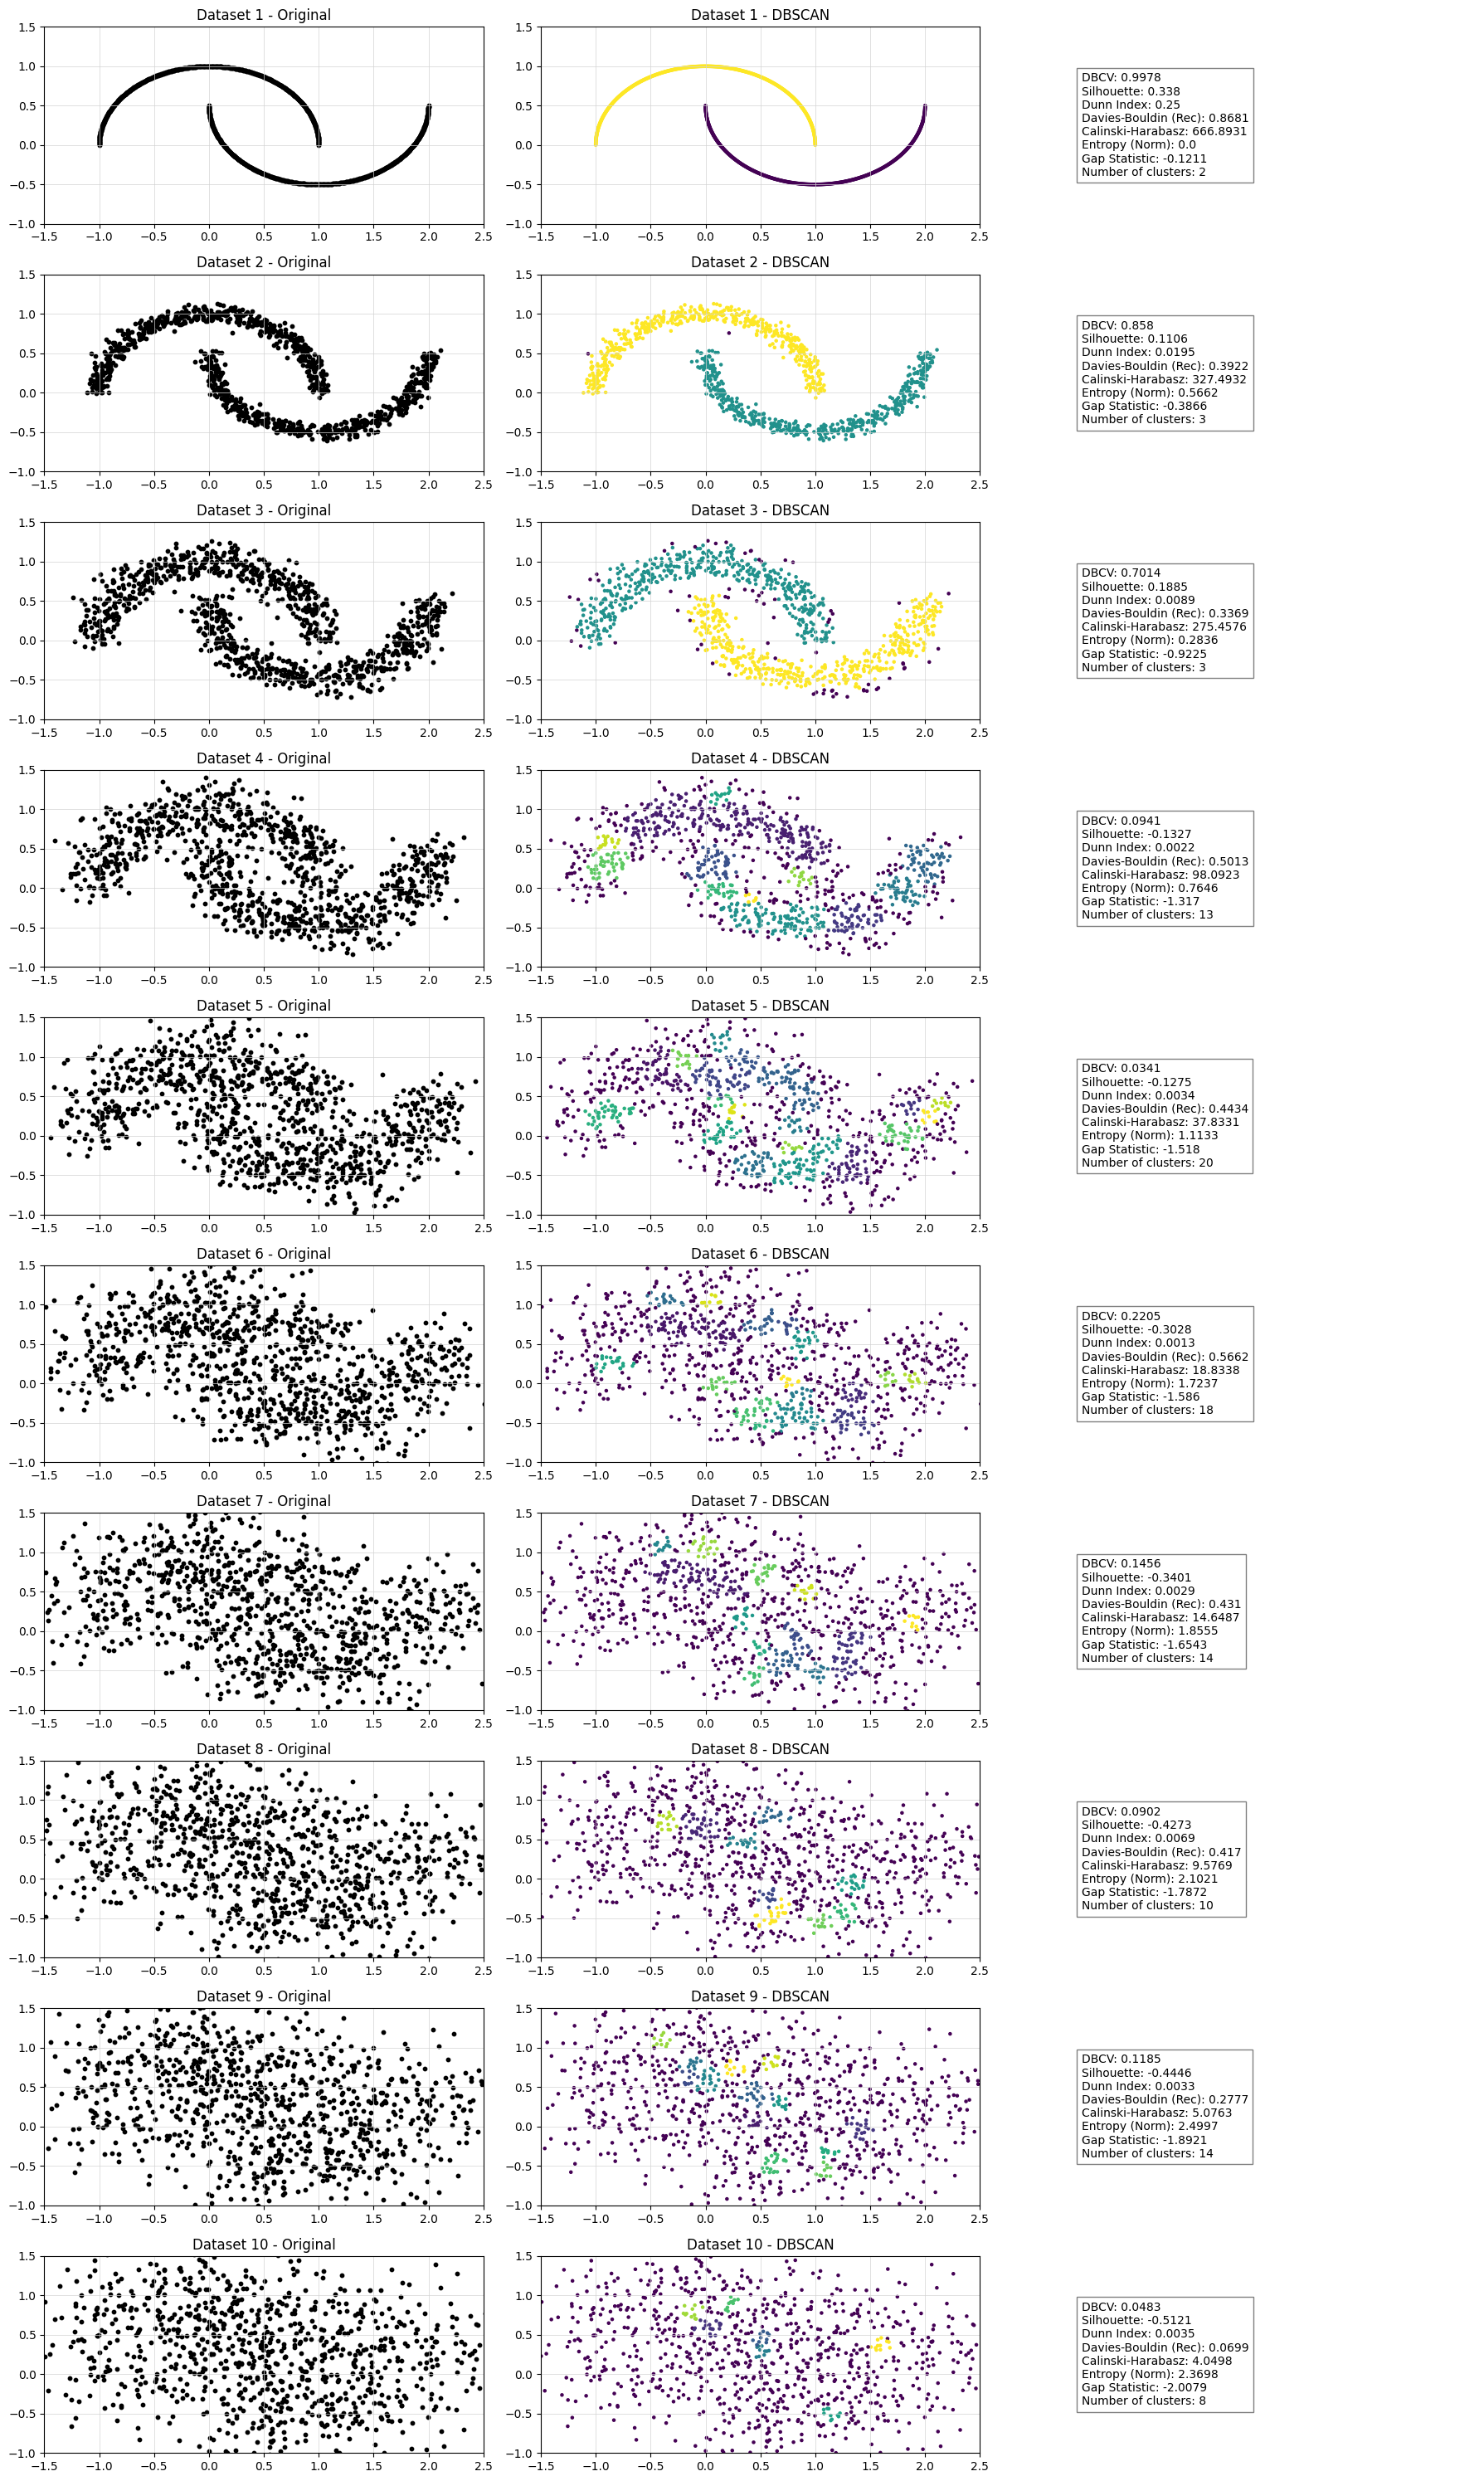

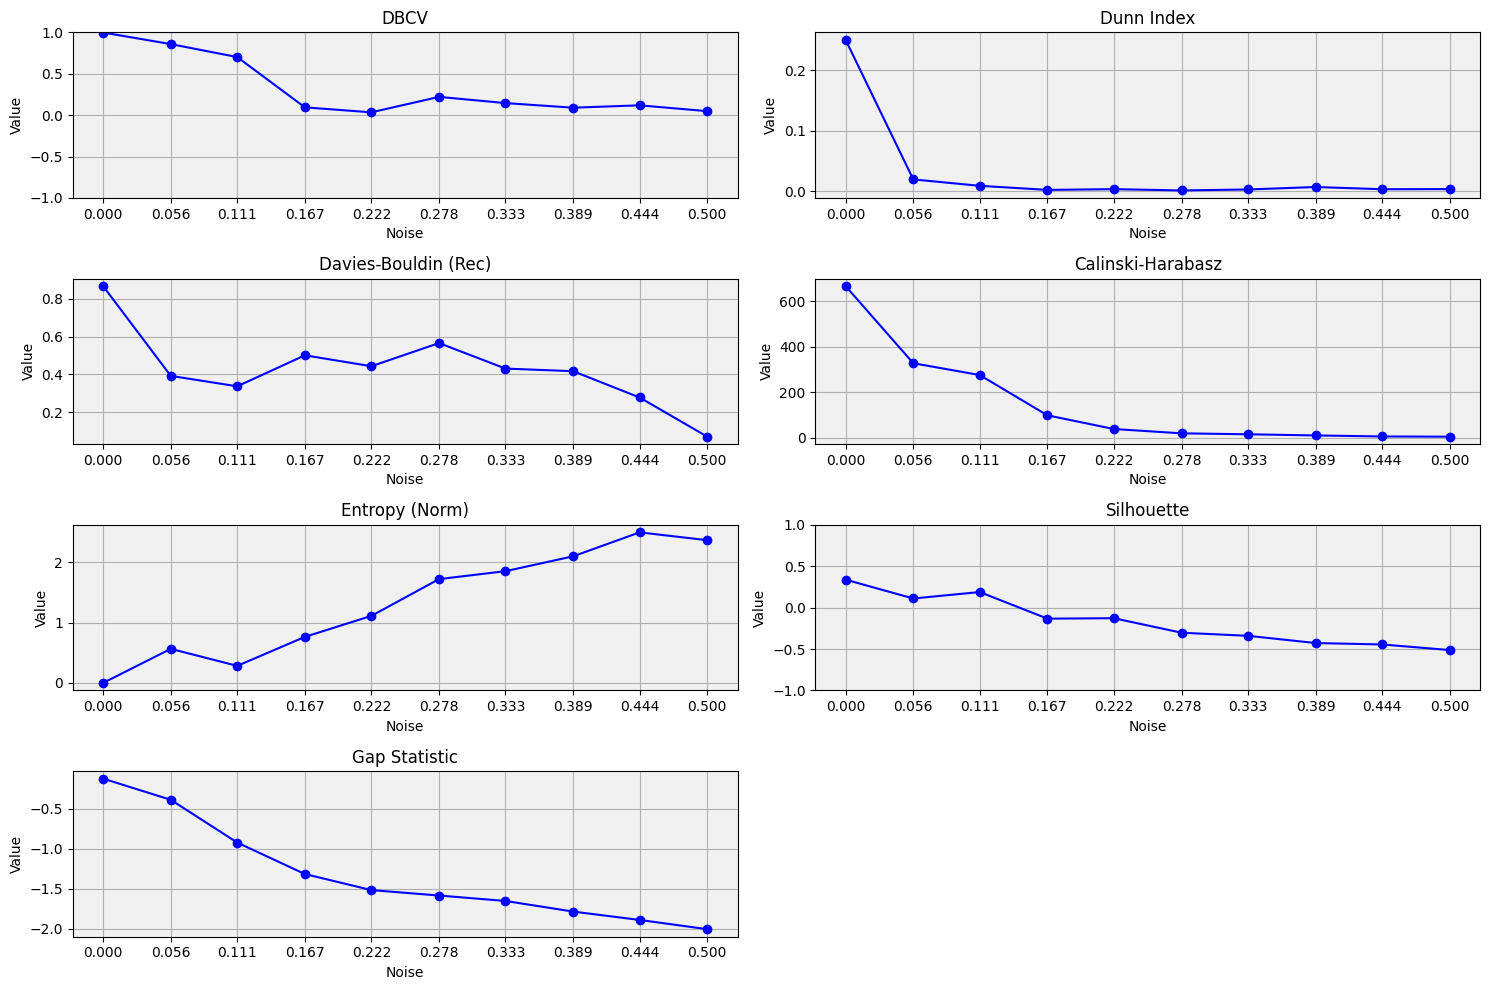

In [ ]:
datasets = generate_moon_datasets(30)
dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering(datasets)
noise = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

**Circle**

Eseguito su 1000 campioni con normal dbcv. Questo perchè fastdbcv da errori di duplicati in fase di calcolo.
CI vuole circa mezz'ora.

Se diminuimo il numero di campioni a 300 il tempo diminuisce notevolmente a 2 minuti.

con 1000 camponi min_samples = 20
con 300 campioni min_samples = 6

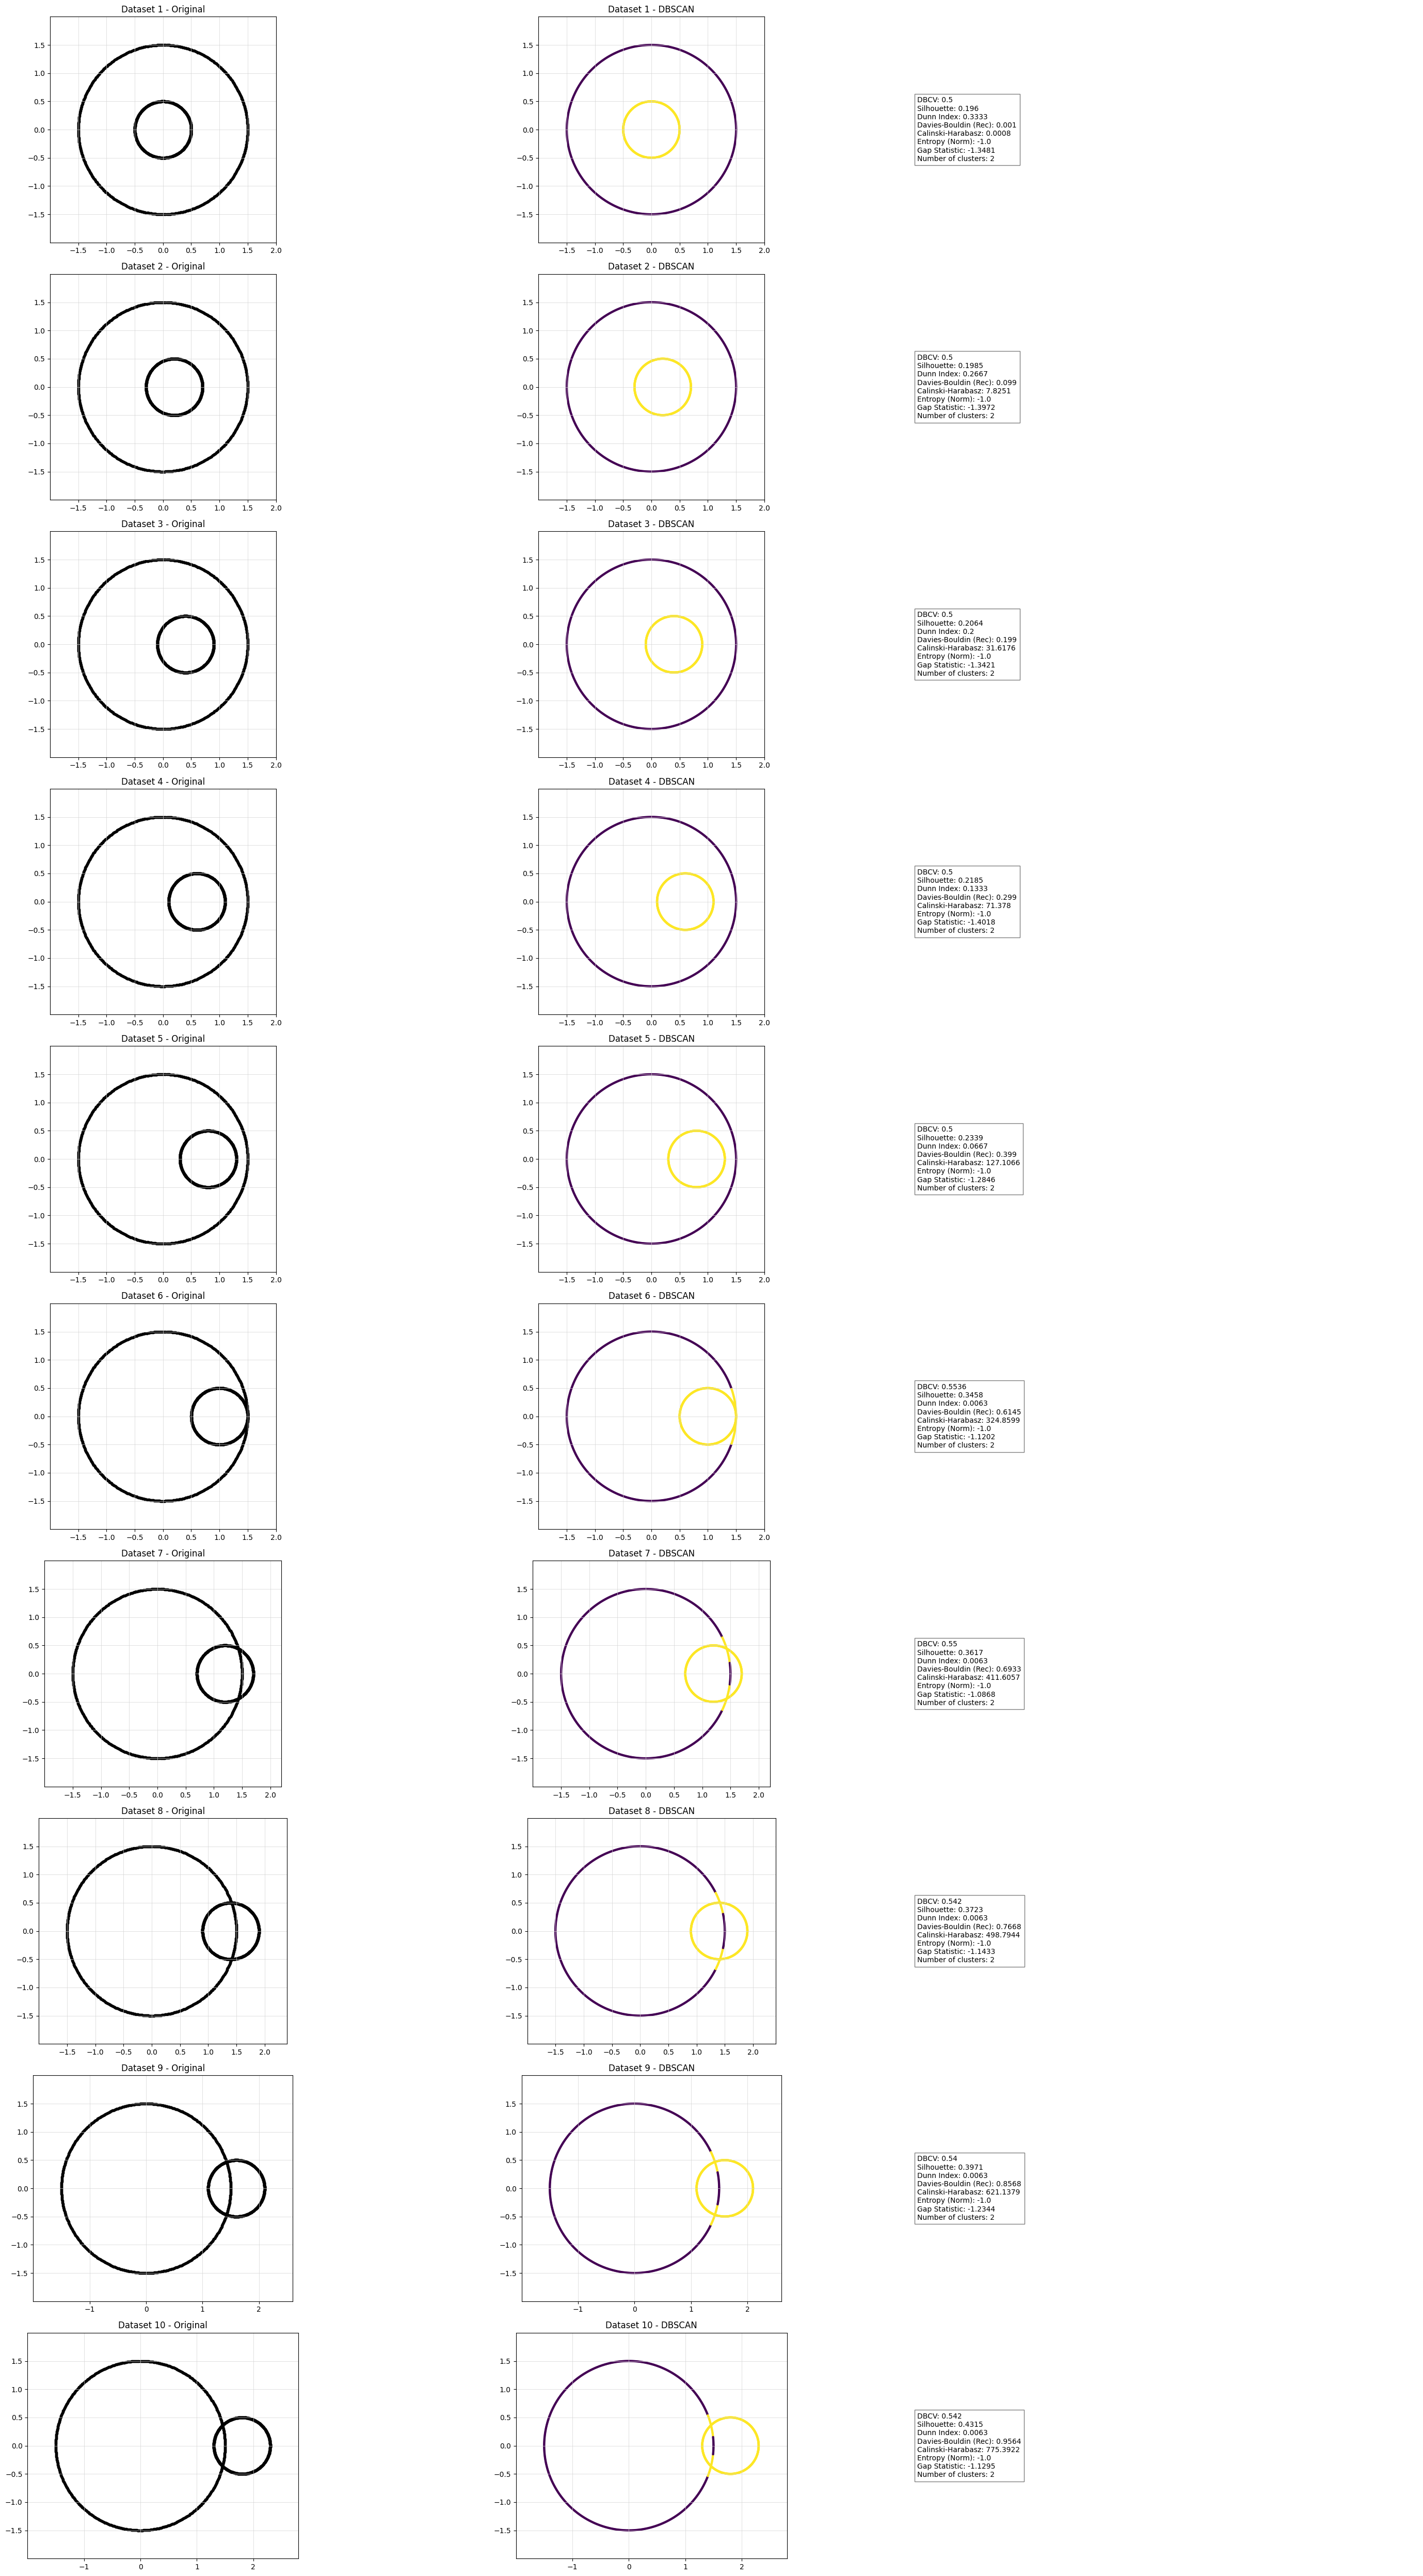

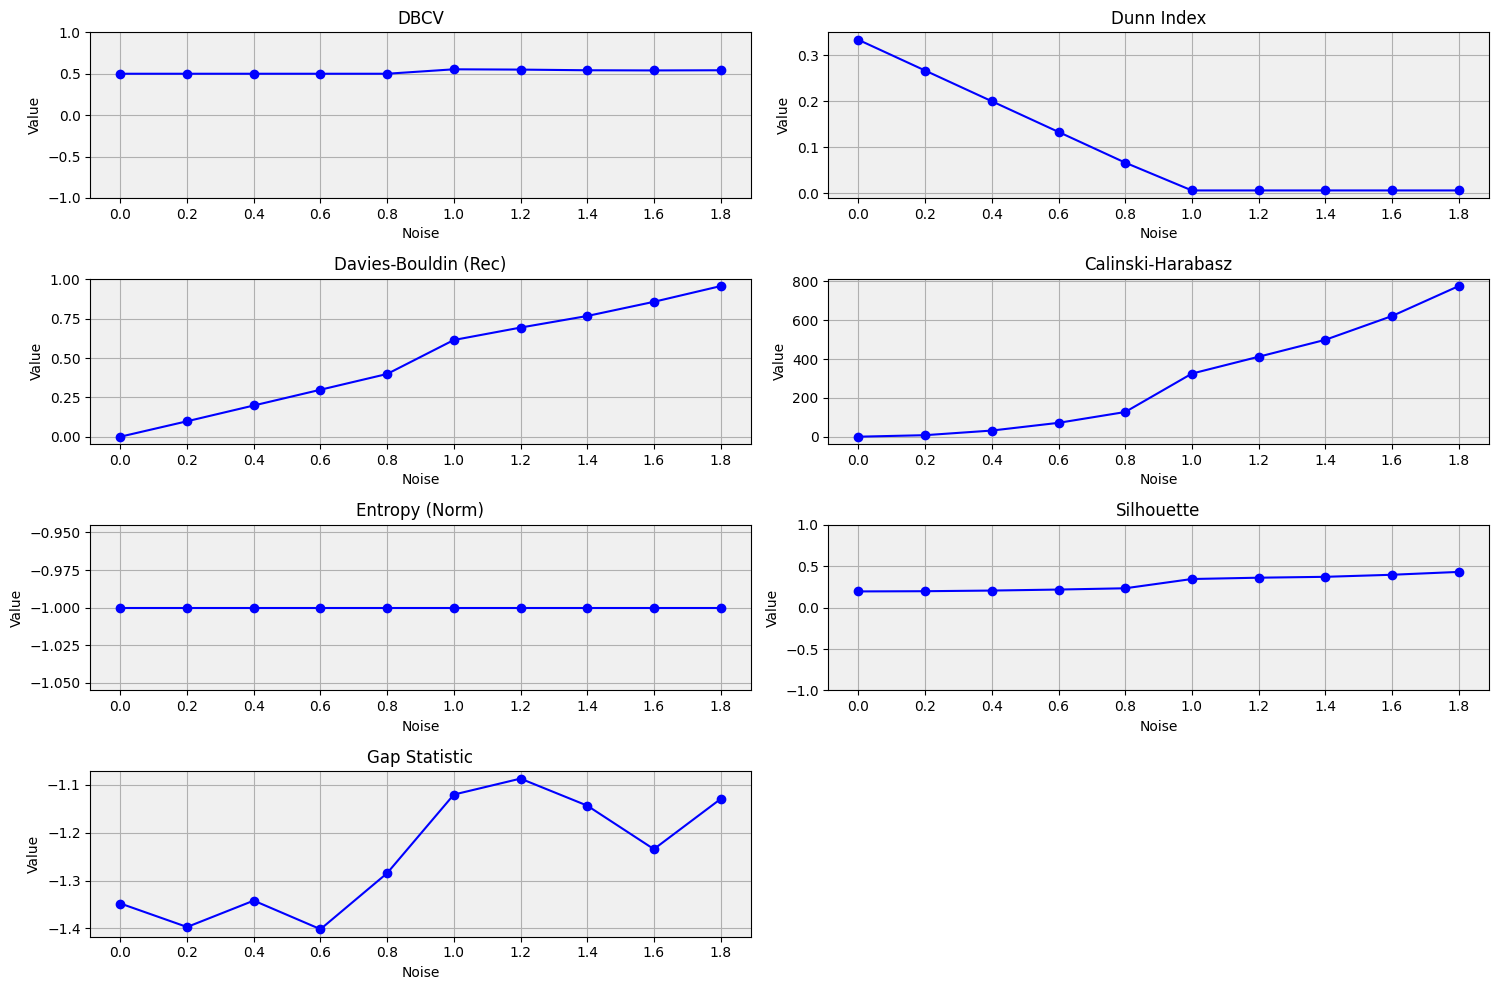

In [ ]:
n_datasets = 10
n_points_per_circle = 500
n_points_per_circle_inner = 500
inner_radius = 0.5
outer_radius = 1.5
initial_shift = (0, 0)
shift_increment = (0.2, 0)
datasets = generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment)

dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_circle(datasets)

noise = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.tight_layout()
plt.show()


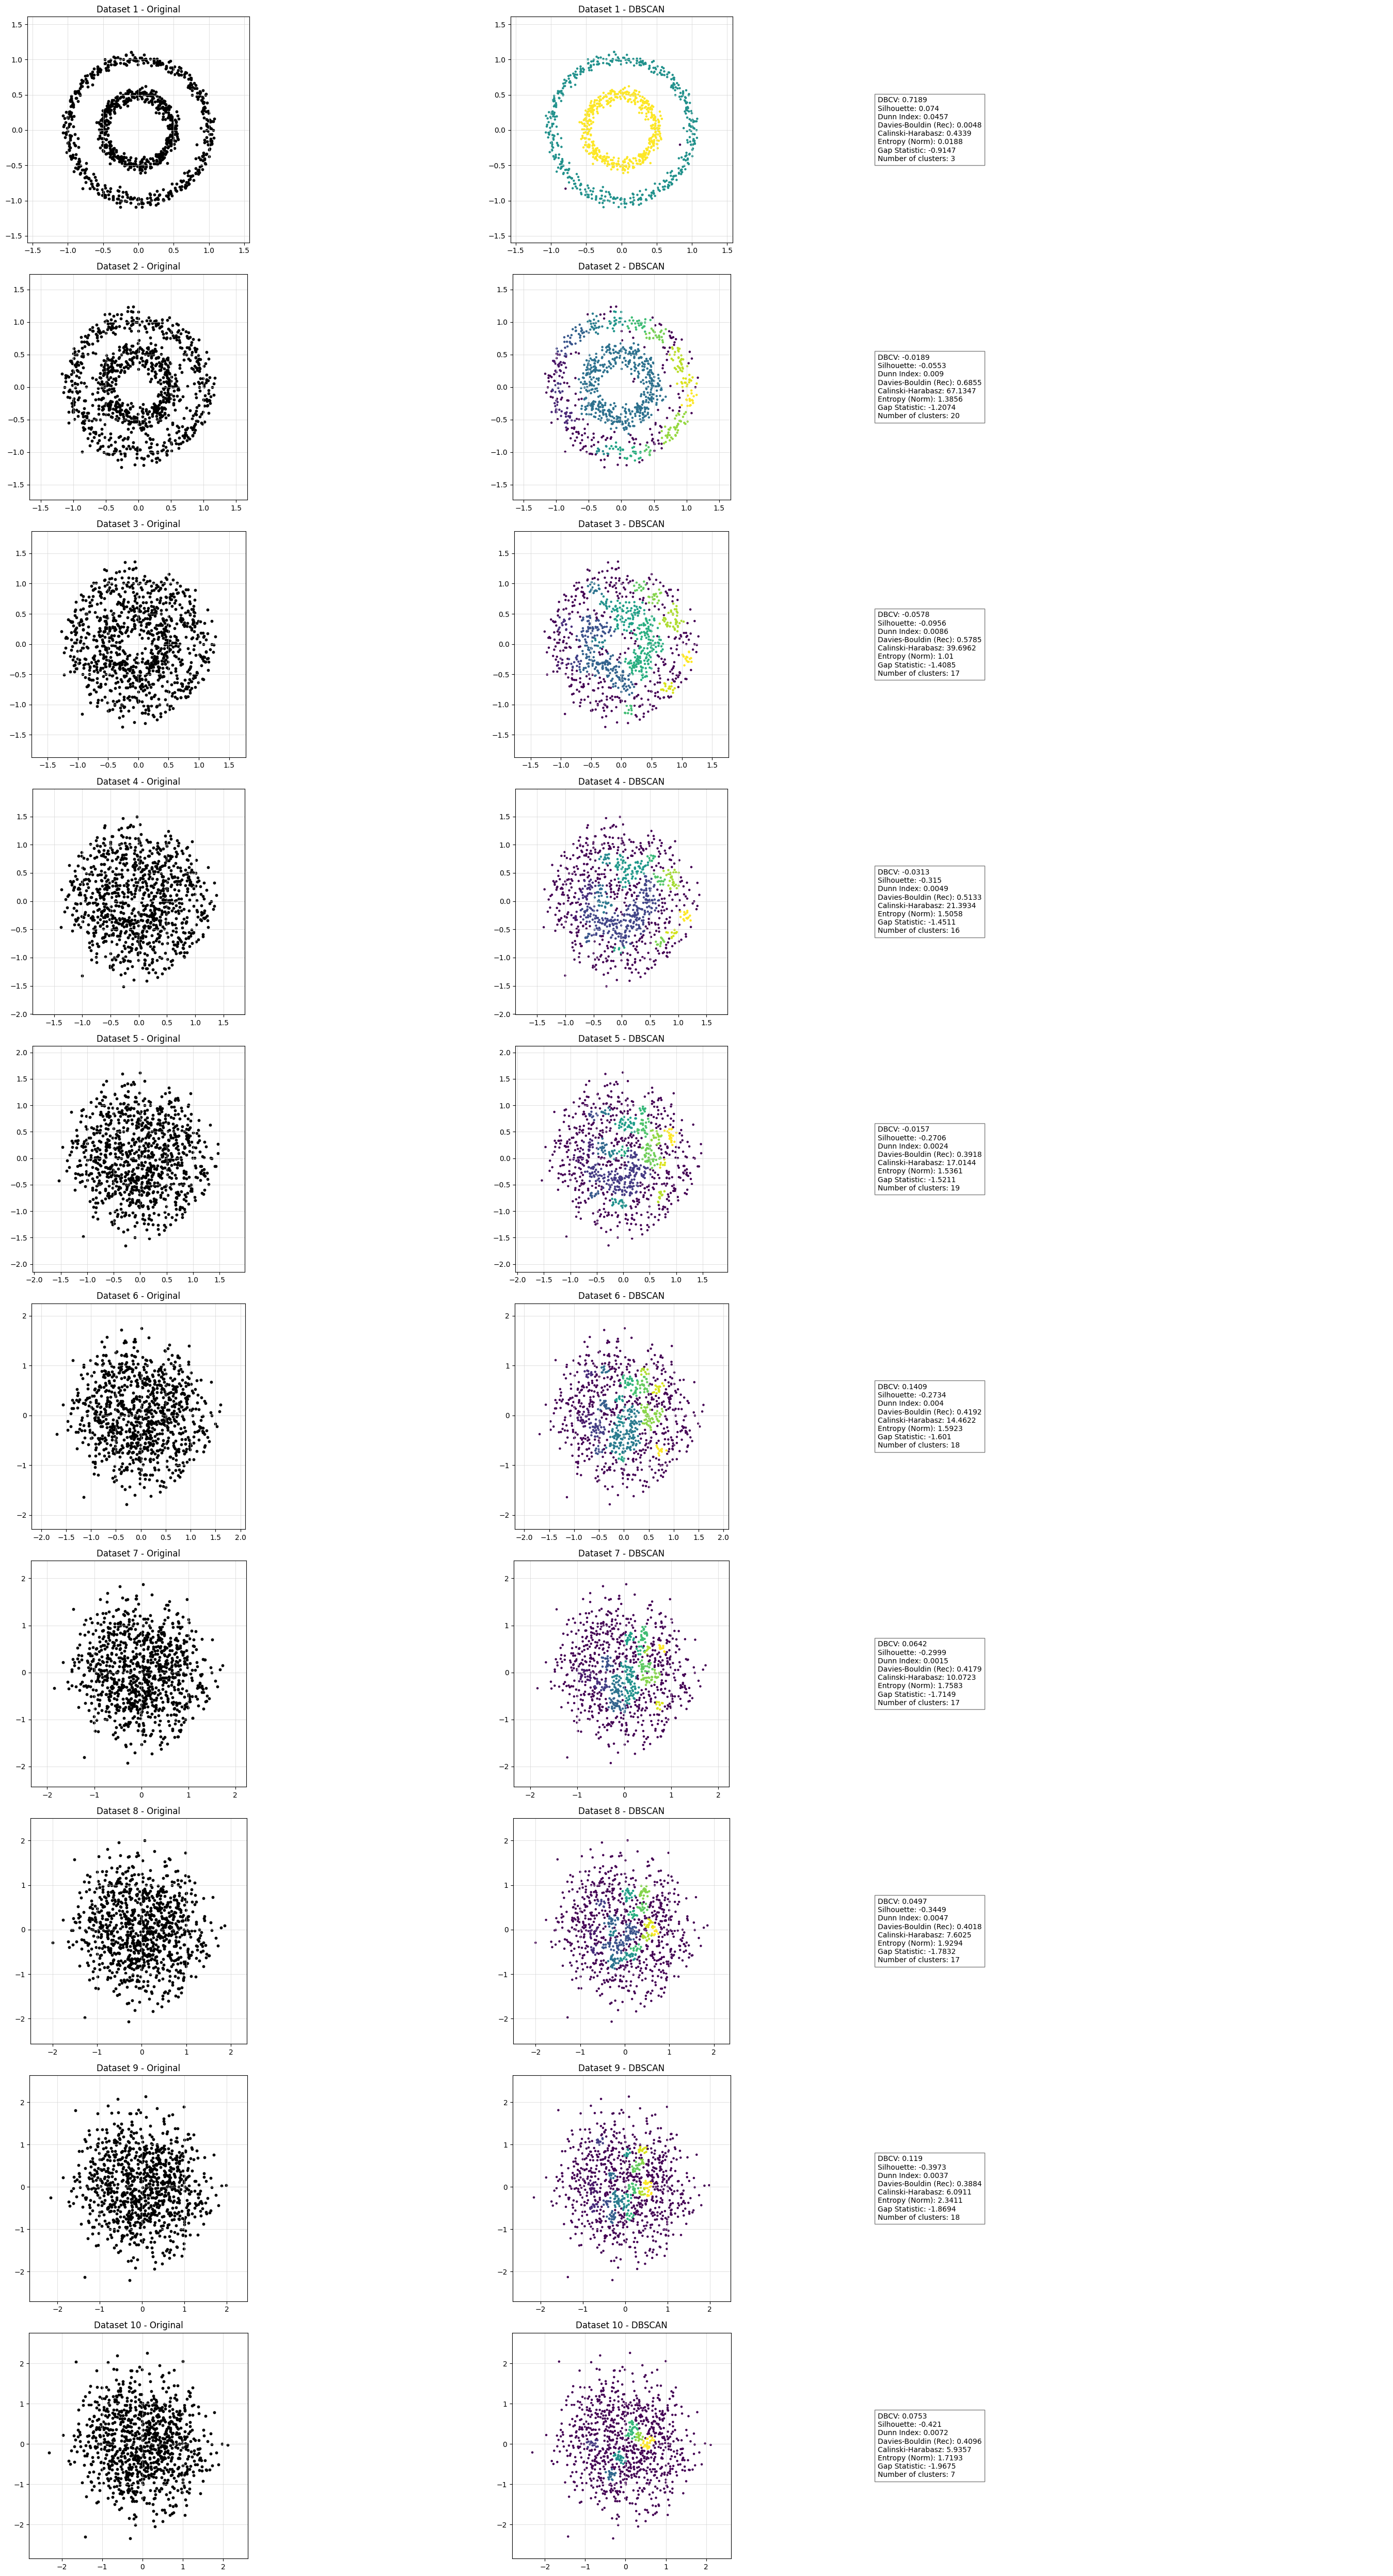

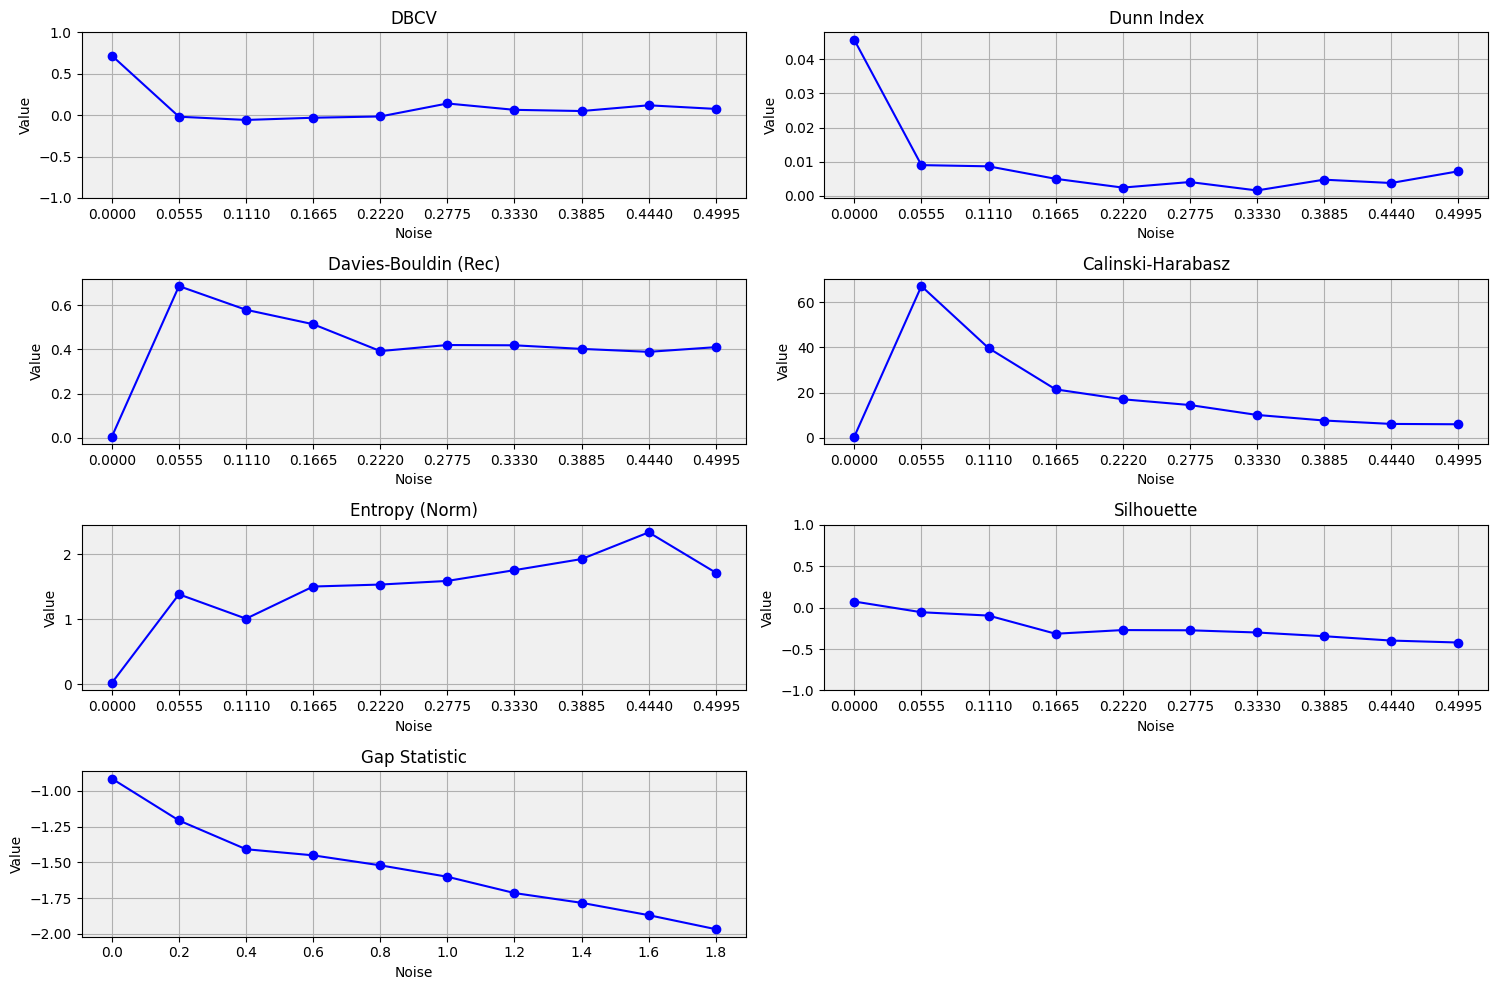

In [ ]:
n_datasets = 10
n_samples = 1000
noise_increment = 0.0555
seed = 4

#noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]


datasets = generate_noisy_circles(n_datasets, n_samples, noise_increment, seed)


dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_noisy_circles(datasets)
noise_levels = [i * noise_increment for i in range(n_datasets)]

dbcv_total = list(zip(dbcv_total, noise_levels))
dunn_total = list(zip(dunn_total, noise_levels))
davies_total = list(zip(davies_total, noise_levels))
calinski_total = list(zip(calinski_total, noise_levels))
entropy_total = list(zip(entropy_total, noise_levels))
silhouette_total = list(zip(silhouette_total, noise_levels))
gap_total = list(zip(gap_total, noise))
data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.tight_layout()
plt.show()


**Tulipan**

Inserire dataset con punti più raggruppati

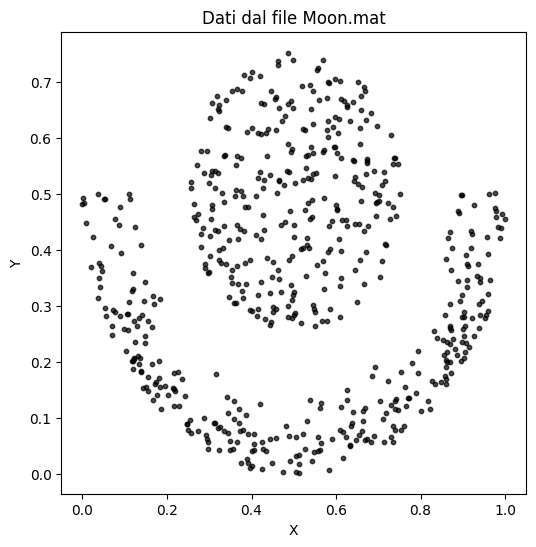

In [ ]:
# preso da https://github.com/adanjoga/cvik-toolbox/tree/master/datasets
#paper A survey of cluster validity indices for automatic data clustering using differential evolution

data = scipy.io.loadmat('/content/Moon.mat')

X = data['data'][:, 0]
Y = data['data'][:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='black', alpha=0.7, s=10)
plt.title("Dati dal file Moon.mat")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


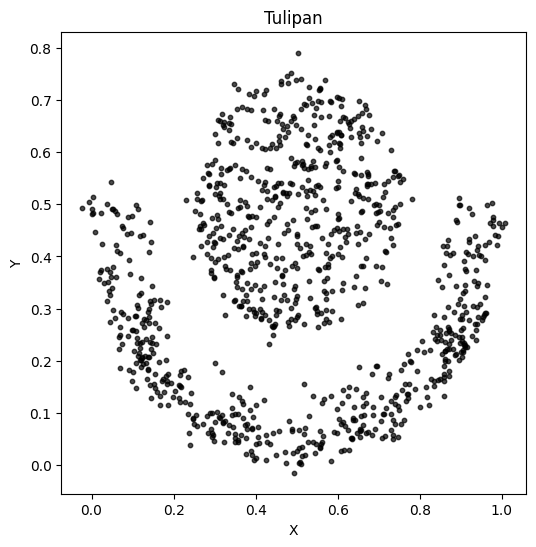

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]


original_points = np.column_stack((X, Y))

# Generate 400 new points by sampling around the existing data
# Adding some random noise to keep them close to the existing distribution
num_new_points = 400
new_points = original_points[np.random.choice(original_points.shape[0], num_new_points)] + np.random.normal(0, 0.02, (num_new_points, 2))
augmented_data = np.vstack((original_points, new_points))
X_augmented = augmented_data[:, 0]
Y_augmented = augmented_data[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X_augmented, Y_augmented, color='black', alpha=0.7, s=10)
plt.title("Tulipan")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

AL dataset originale sono dati aggiutni 400 punti (essendo 600 quelli attuali). I 600 attualirimangono fissi, viene aggiunto del rumore ai 400 inseriti , normalizzando il loro valore tra 0 e 1 in modo da essere inseritiall'interno del tulipano e non all'esterno

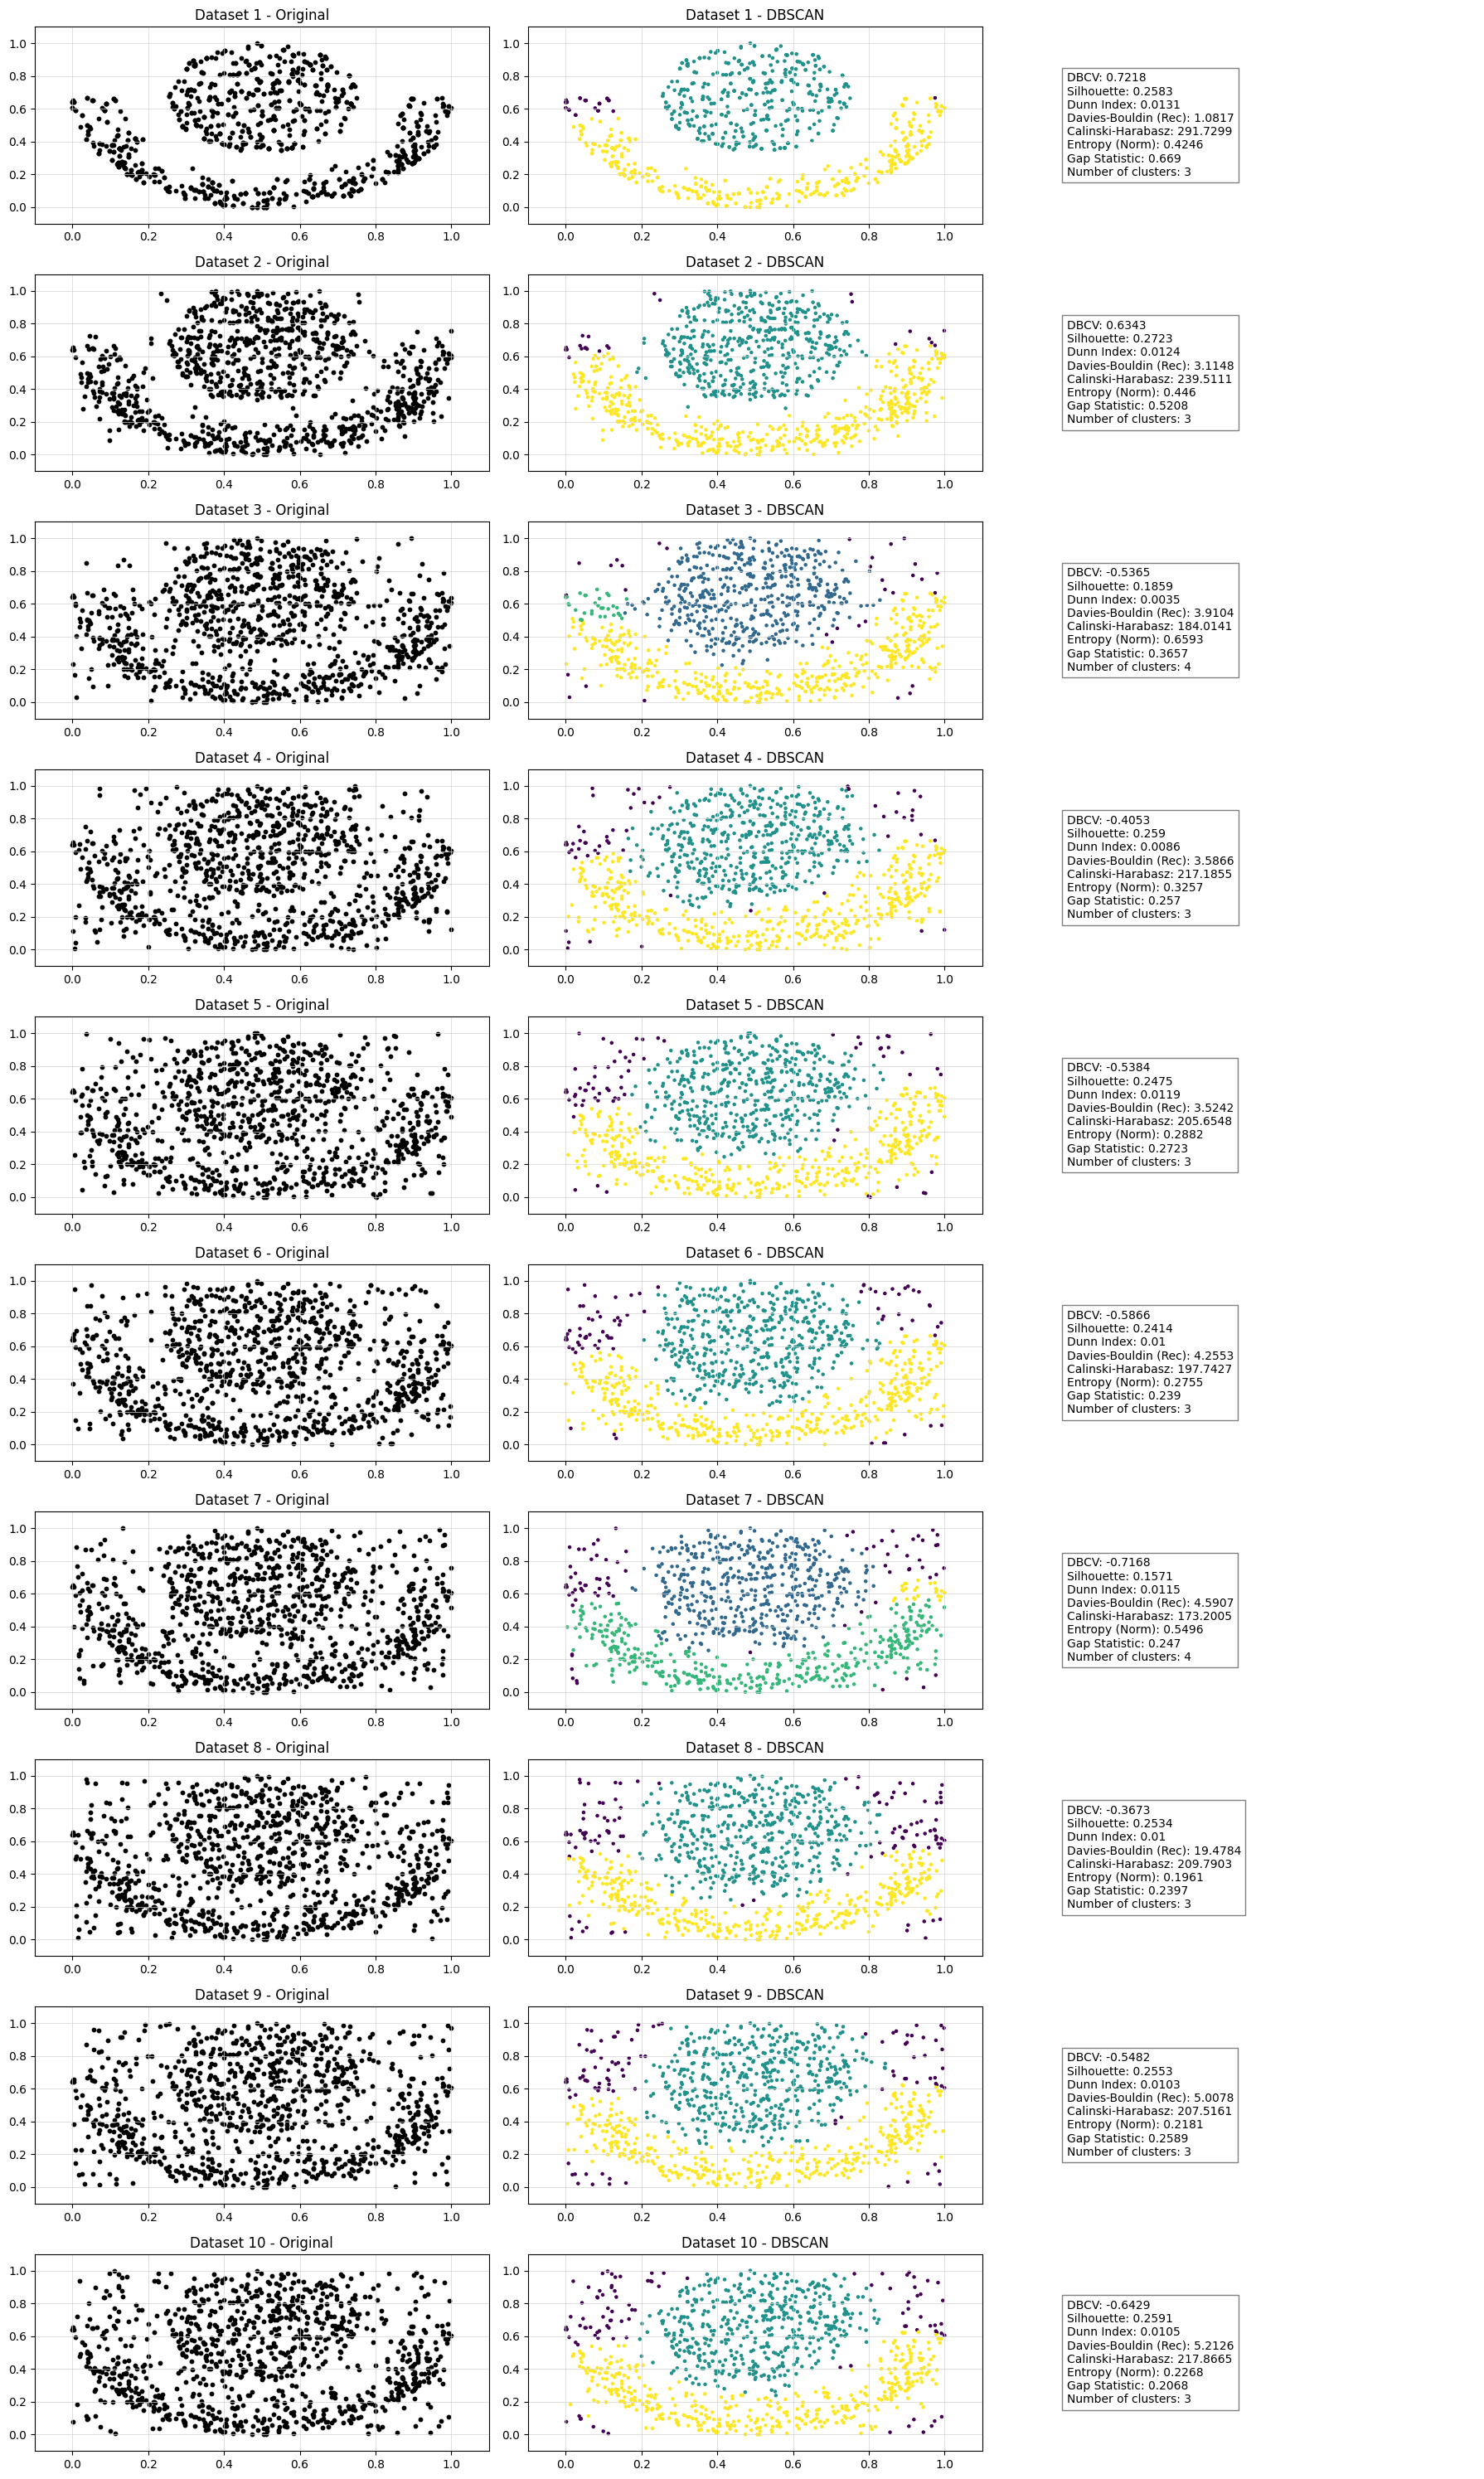

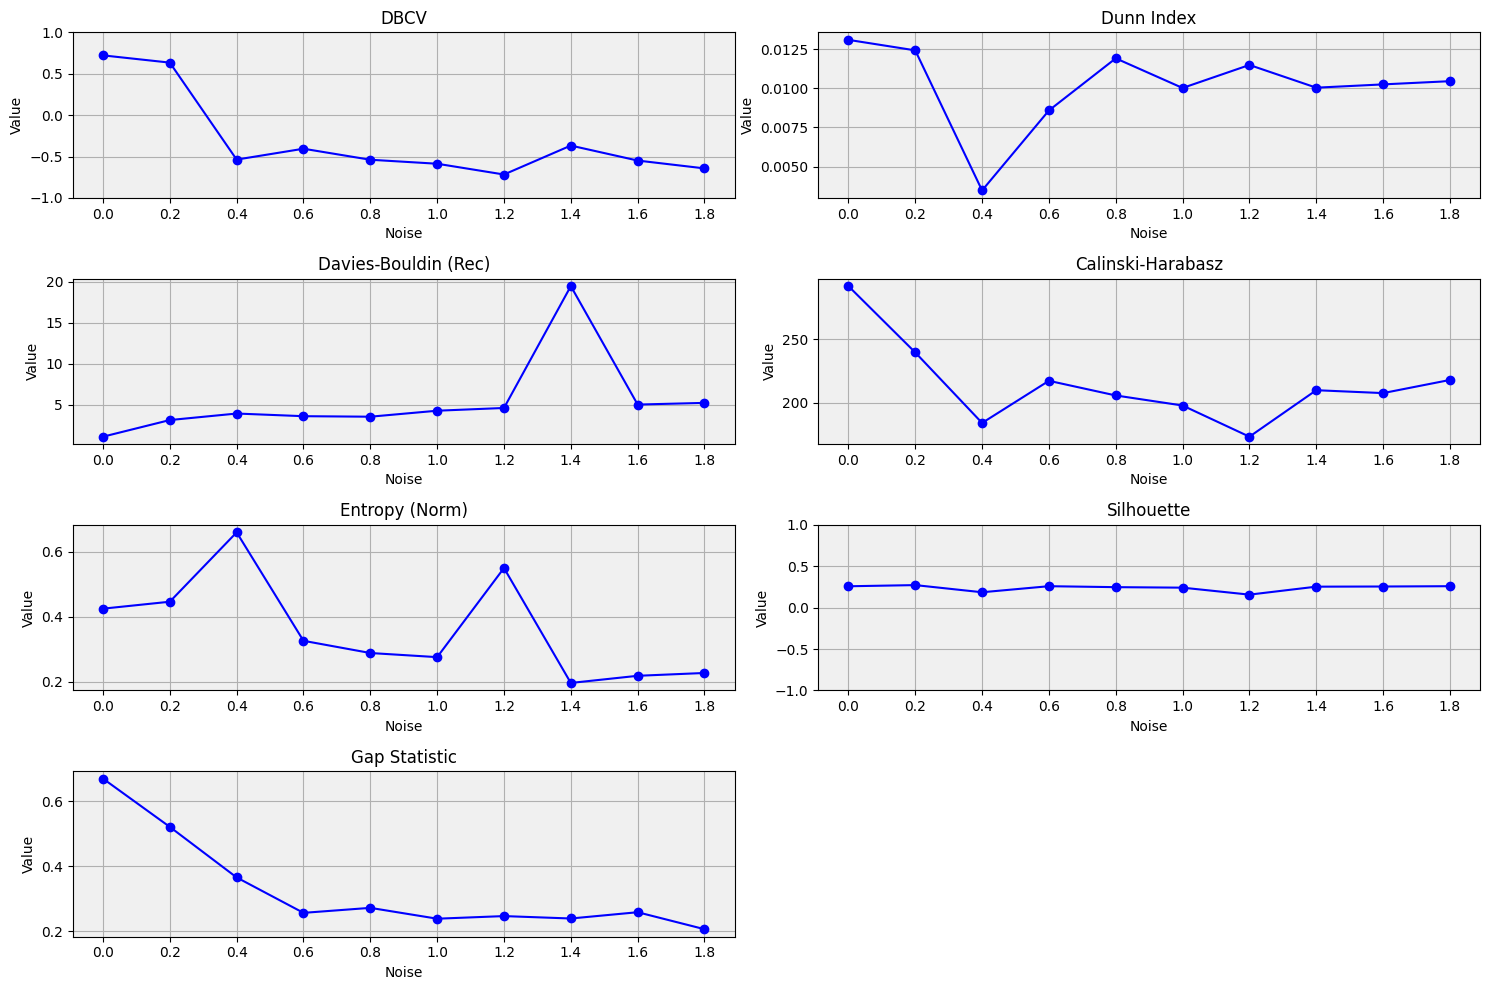

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]
original_points = np.column_stack((X, Y))

min_vals = original_points.min(axis=0)
max_vals = original_points.max(axis=0)
normalized_points = (original_points - min_vals) / (max_vals - min_vals)

datasets = generate_augmented_datasets(30)
results = analyze_datasets_tulipan(datasets)
dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_tulipan(datasets, results)

noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))
for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)
    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)
    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')
    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.tight_layout()
plt.show()


#**EHRs**

In [120]:
neuroblastoma=pd.read_csv("/content/10_7717_peerj_5665_dataYM2018_neuroblastoma.csv")
diabetes=pd.read_csv("/content/journal.pone.0216416_Takashi2019_diabetes_type1_dataset_preprocessed.csv")
sepsis=pd.read_csv("/content/journal.pone.0148699_S1_Text_Sepsis_SIRS_EDITED.csv")
heart_failure=pd.read_csv("/content/journal.pone.0158570_S2File_depression_heart_failure_v2.csv")
cardiac_arrest=pd.read_csv("/content/journal.pone.0175818_S1Dataset_Spain_cardiac_arrest_EDITED..csv")
df_metrics=pd.DataFrame()

metric_colors = {
    "DBCV Score": '#1f77b4',
    "Silhouette": '#ff7f0e',
    "Dunn Index": '#2ca02c',
    "Davies-Bouldin Norm": '#d62728',
    "Calinski-Harabasz": '#9467bd',
    "Shannon Entropy Norm": '#8c564b',
    "Optimal Gap Statistic": '#e377c2',
    "Clustering Truth": '#7f7f7f',
    "ARI": '#bcbd22'
}

metrics = [
    "DBCV Score", "Silhouette", "Dunn Index", "Davies-Bouldin Norm",
    "Calinski-Harabasz", "Entropy Norm", "Gap Statistic"
]

clustering_methods = ["HDBSCAN", "DBSCAN", "Meanshift", "HDBSCAN_default", "DBSCAN_default", "Meanshift_default"]

#**Neuroblastoma**

In [121]:
neuroblastoma = neuroblastoma.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = neuroblastoma.columns
scaler_minmax = MinMaxScaler()
neuroblastoma_scaled = neuroblastoma.copy()
neuroblastoma_scaled[numerical_features] = scaler_minmax.fit_transform(neuroblastoma[numerical_features])
neuroblastoma_scaled.reset_index(drop=True, inplace=True)
neuroblastoma_scaled.drop_duplicates(inplace=True)
df_metrics_neuroblastoma = pd.DataFrame()
neuroblastoma_scaled

age  sex  site  stage  risk  time_months  \
0    1.0  0.0   0.0    1.0   1.0     0.060606   
1    1.0  0.0   0.0    1.0   1.0     0.181818   
2    0.5  0.0   0.0    1.0   1.0     0.242424   
3    0.5  0.0   0.0    1.0   1.0     0.070707   
4    0.5  0.0   0.0    1.0   1.0     0.464646   
..   ...  ...   ...    ...   ...          ...   
164  0.0  0.0   0.0    0.0   0.0     0.353535   
165  0.5  0.0   0.0    0.0   0.0     0.171717   
166  0.5  1.0   0.5    0.0   0.0     0.373737   
167  0.5  1.0   0.5    0.0   0.0     0.363636   
168  0.0  0.0   0.0    0.0   0.0     0.313131   

     autologous_stem_cell_transplantation  radiation  \
0                                     0.0        0.0   
1                                     0.0        1.0   
2                                     0.0        1.0   
3                                     0.0        0.0   
4                                     1.0        1.0   
..                                    ...        ...   
164                                   0.0        0.0   
165                                   0.0        0.0   
166                                   0.0        0.0   
167                                   0.0        0.0   
168                                   0.0        0.0   

     degree_of_differentiation  UH_or_FH  MYCN_status   surgical_methods  \
0                          0.0       0.0           1.0               1.0   
1                          0.0       0.0           1.0               1.0   
2                          0.5       0.0           1.0               0.0   
3                          0.5       0.0           1.0               1.0   
4                          0.5       0.0           1.0               0.0   
..                         ...       ...           ...               ...   
164                        0.0       0.0           1.0               0.0   
165                        0.5       1.0           1.0               1.0   
166                        1.0       1.0           1.0               0.0   
167                        0.5       1.0           1.0               0.0   
168                        0.0       0.0           1.0               0.0   

     outcome  
0        0.0  
1        1.0  
2        1.0  
3        0.0  
4        1.0  
..       ...  
164      0.0  
165      1.0  
166      0.0  
167      0.0  
168      0.0  

[168 rows x 13 columns]

**HDBSCAN**

In [122]:
min_size, epsilon= best_params_hdbscan(neuroblastoma_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default = hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(neuroblastoma_scaled)
labels_default = hdbscan_cluster_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['HDBSCAN_pred'] = labels
methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels_default)
neuroblastoma_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)


min_cluster_size: 15, cluster_selection_epsilon: 0.01


**DBSCAN**

In [123]:
min_sample, eps = best_params_dbscan(neuroblastoma_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(neuroblastoma_scaled)
labels_default = dbscan_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels_default)
neuroblastoma_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Meanshift**

In [124]:
band = best_params_mean_shift(neuroblastoma_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(neuroblastoma_scaled)
labels_default = mean_shift_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels_default)
neuroblastoma_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)
df_metrics_neuroblastoma

Best bandwidth: 1.516


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.50        0.18    0.068486                 0.40   
1    HDBSCAN_default       -0.03        0.24    0.146895                 0.48   
2             DBSCAN        0.20       -0.06    0.122856                 0.74   
3     DBSCAN_default        0.07        0.06    0.111232                 0.94   
4          Meanshift        0.50        0.33    0.450765                 1.50   
5  Meanshift_default       -0.96        0.24    0.042548                 0.74   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              22.48          0.45           0.01  
1              27.61          0.50           0.02  
2               3.09          1.85           0.06  
3              25.24          1.17          -0.15  
4             102.17          1.41          -0.04  
5              34.23          0.50          -0.17

**Cluster Analysis**

In [127]:
cluster_similarity = similar_cluster(neuroblastoma_scaled)
cluster_similarity

[ 0  5  7  3 19  9 13 16  4  6 15 25 17 10 12 11 22 18 26 21 14 20  8  2
  1 23 24]
[-1  0  1  2  3  6  4  5  7  8  9 10 12 11 13]
[ 0 -1  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0              0      -1        0    42.261905
1082           1      -1        1     5.952381
1036           2      -1       -1     5.357143
102            7       3        0     3.571429
150            3       6        0     2.976190
...          ...     ...      ...          ...
410            6       0        1     0.000000
409            6       0       -1     0.000000
408            6       0        0     0.000000
407            6      -1        1     0.000000
1214          24      13        1     0.000000

[1215 rows x 4 columns]

In [128]:
cluster_similarity_default = similar_cluster_default(neuroblastoma_scaled)
cluster_similarity_default

[0 1 2]
[-1  0  1]
[ 1 -1  0]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0            0      -1        1    50.000000
18           2      -1        1    14.285714
1            0      -1       -1    11.904762
2            0      -1        0    11.309524
9            1      -1        1     5.952381
12           1       0        1     3.571429
26           2       1        0     2.976190
7            0       1       -1     0.000000
8            0       1        0     0.000000
25           2       1       -1     0.000000
24           2       1        1     0.000000
23           2       0        0     0.000000
22           2       0       -1     0.000000
21           2       0        1     0.000000
20           2      -1        0     0.000000
19           2      -1       -1     0.000000
3            0       0        1     0.000000
17           1       1        0     0.000000
16           1       1       -1     0.000000
15           1       1        1     0.000000
14           1       0        0     0.000000
4            0       0       -1     0.000000
5            0       0        0     0.000000
11           1      -1        0     0.000000
10           1      -1       -1     0.000000
6            0       1        1     0.000000
13           1       0       -1     0.000000

In [129]:
neuroblastoma_scaled["DBSCAN_pred"] = neuroblastoma_scaled["DBSCAN_pred"].astype(object)
neuroblastoma_scaled["HDBSCAN_pred"] = neuroblastoma_scaled["HDBSCAN_pred"].astype(object)
neuroblastoma_scaled["Mean_shift_pred"] = neuroblastoma_scaled["Mean_shift_pred"].astype(object)

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'B'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == 1, "DBSCAN_default_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 0, "HDBSCAN_default_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'B'

neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

neuroblastoma_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

same_value_count = (neuroblastoma_scaled["HDBSCAN_pred"] == neuroblastoma_scaled["DBSCAN_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_pred"] == neuroblastoma_scaled["Mean_shift_pred"])

same_value_count_default = (neuroblastoma_scaled["HDBSCAN_default_pred"] == neuroblastoma_scaled["DBSCAN_default_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_default_pred"] == neuroblastoma_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(neuroblastoma_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(neuroblastoma_scaled)


percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(neuroblastoma_scaled)

df_metrics_neuroblastoma['Clustering Truth'] = df_metrics_neuroblastoma['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_neuroblastoma['ARI'] = df_metrics_neuroblastoma['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_neuroblastoma = df_metrics_neuroblastoma.sort_values('DBCV Score', ascending=False)
df_metrics_neuroblastoma

Totale delle righe con lo stesso valore: 80
Percentuale rispetto al totale: 47.62 %
Totale delle righe con lo stesso valore con parametri default: 89
Percentuale rispetto al totale: 52.98 %


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.50        0.18    0.068486                 0.40   
4          Meanshift        0.50        0.33    0.450765                 1.50   
2             DBSCAN        0.20       -0.06    0.122856                 0.74   
3     DBSCAN_default        0.07        0.06    0.111232                 0.94   
1    HDBSCAN_default       -0.03        0.24    0.146895                 0.48   
5  Meanshift_default       -0.96        0.24    0.042548                 0.74   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
0              22.48          0.45           0.01             0.476  0.295584  
4             102.17          1.41          -0.04             0.476  0.295584  
2               3.09          1.85           0.06             0.476  0.295584  
3              25.24          1.17          -0.15             0.530  0.101290  
1              27.61          0.50           0.02             0.530  0.101290  
5              34.23          0.50          -0.17             0.530  0.101290

In [132]:
df_metrics_neuroblastoma["Silhouette"] = (df_metrics_neuroblastoma["Silhouette"] + 1) / 2
df_metrics_neuroblastoma["DBCV Score"] = (df_metrics_neuroblastoma["DBCV Score"] + 1) / 2
df_metrics_neuroblastoma["Dunn Index"] = (erf(df_metrics_neuroblastoma["Dunn Index"]) + 1) / 2
df_metrics_neuroblastoma["Davies-Bouldin Norm"] = (erf(df_metrics_neuroblastoma["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_neuroblastoma["Calinski-Harabasz"] = 1 - (1 / df_metrics_neuroblastoma["Calinski-Harabasz"])
df_metrics_neuroblastoma["Entropy Norm"] = (erf(df_metrics_neuroblastoma["Entropy Norm"]) + 1) / 2
df_metrics_neuroblastoma["Gap Statistic"] = (erf(df_metrics_neuroblastoma["Gap Statistic"]) + 1) / 2

df_metrics_neuroblastoma

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN       0.750       0.590    0.538579             0.714196   
4          Meanshift       0.750       0.665    0.738093             0.983053   
2             DBSCAN       0.600       0.470    0.568967             0.852339   
3     DBSCAN_default       0.535       0.530    0.562498             0.908136   
1    HDBSCAN_default       0.485       0.620    0.582284             0.751375   
5  Meanshift_default       0.020       0.620    0.523991             0.852339   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
0           0.955516      0.737741       0.505642             0.476  0.295584  
4           0.990212      0.976926       0.477444             0.476  0.295584  
2           0.676375      0.995556       0.533811             0.476  0.295584  
3           0.960380      0.951000       0.416002             0.530  0.101290  
1           0.963781      0.760250       0.511282             0.530  0.101290  
5           0.970786      0.760250       0.405004             0.530  0.101290

In [133]:
distance_table_neuroblastoma = df_metrics_neuroblastoma.copy()

for metric in metrics:
    distance_table_neuroblastoma[metric] = np.sqrt((df_metrics_neuroblastoma[metric] - df_metrics_neuroblastoma["Clustering Truth"]) ** 2)

distance_table_neuroblastoma = distance_table_neuroblastoma.sort_values(by="DBCV Score", ascending=True)
distance_table_neuroblastoma.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_neuroblastoma.columns
]

distance_table_neuroblastoma

Method  DBCV Score Distance  Silhouette Distance  \
3     DBSCAN_default                0.005                0.000   
1    HDBSCAN_default                0.045                0.090   
2             DBSCAN                0.124                0.006   
0            HDBSCAN                0.274                0.114   
4          Meanshift                0.274                0.189   
5  Meanshift_default                0.510                0.090   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
3             0.032498                      0.378136   
1             0.052284                      0.221375   
2             0.092967                      0.376339   
0             0.062579                      0.238196   
4             0.262093                      0.507053   
5             0.006009                      0.322339   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
3                    0.430380               0.421000                0.113998   
1                    0.433781               0.230250                0.018718   
2                    0.200375               0.519556                0.057811   
0                    0.479516               0.261741                0.029642   
4                    0.514212               0.500926                0.001444   
5                    0.440786               0.230250                0.124996   

   Clustering Truth       ARI  
3             0.530  0.101290  
1             0.530  0.101290  
2             0.476  0.295584  
0             0.476  0.295584  
4             0.476  0.295584  
5             0.530  0.101290

**No normalizzazione**

In [131]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_neuroblastoma.columns:
            best_value = distance_table_neuroblastoma.loc[distance_table_neuroblastoma["Method"] == method, metric_value].values[0]
            default_value = distance_table_neuroblastoma.loc[distance_table_neuroblastoma["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_neuroblastoma,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters    Default     Method trend  \
0                DBCV         0.276000   0.460000     DBSCAN     ↑   
1          Silhouette         0.536000   0.470000     DBSCAN     ↓   
2                Dunn         0.353144   0.418768     DBSCAN     ↑   
3      Davies-Bouldin         0.264000   0.410000     DBSCAN     ↑   
4   Calinski-Harabasz         2.614000  24.710000     DBSCAN     ↑   
5             Entropy         1.374000   0.640000     DBSCAN     ↓   
6                 Gap         0.416000   0.680000     DBSCAN     ↑   
7                DBCV         0.024000   0.560000    HDBSCAN     ↑   
8          Silhouette         0.296000   0.290000    HDBSCAN     ↓   
9                Dunn         0.407514   0.383105    HDBSCAN     ↓   
10     Davies-Bouldin         0.076000   0.050000    HDBSCAN     ↓   
11  Calinski-Harabasz        22.004000  27.080000    HDBSCAN     ↑   
12            Entropy         0.026000   0.030000    HDBSCAN     ↑   
13                Gap         0.466000   0.510000    HDBSCAN     ↑   
14               DBCV         0.024000   1.490000  Meanshift     ↑   
15         Silhouette         0.146000   0.290000  Meanshift     ↑   
16               Dunn         0.025235   0.487452  Meanshift     ↑   
17     Davies-Bouldin         1.024000   0.210000  Meanshift     ↓   
18  Calinski-Harabasz       101.694000  33.700000  Meanshift     ↓   
19            Entropy         0.934000   0.030000  Meanshift     ↓   
20                Gap         0.516000   0.700000  Meanshift     ↑   

   trend consistency with reality  
0                      Consistent  
1                    Inconsistent  
2                      Consistent  
3                      Consistent  
4                      Consistent  
5                    Inconsistent  
6                      Consistent  
7                      Consistent  
8                    Inconsistent  
9                    Inconsistent  
10                   Inconsistent  
11                     Consistent  
12                     Consistent  
13                     Consistent  
14                     Consistent  
15                     Consistent  
16                     Consistent  
17                   Inconsistent  
18                   Inconsistent  
19                   Inconsistent  
20                     Consistent

**Normalizzazione**

In [74]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_neuroblastoma.columns:
            best_value = distance_table_neuroblastoma.loc[distance_table_neuroblastoma["Method"] == method, metric_value].values[0]
            default_value = distance_table_neuroblastoma.loc[distance_table_neuroblastoma["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_neuroblastoma,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.154000  0.005000     DBSCAN     ↓   
1          Silhouette         0.024000  0.000000     DBSCAN     ↓   
2                Dunn         0.122967  0.032498     DBSCAN     ↓   
3      Davies-Bouldin         0.406339  0.378136     DBSCAN     ↓   
4   Calinski-Harabasz         0.230375  0.430380     DBSCAN     ↑   
5             Entropy         0.549556  0.421000     DBSCAN     ↓   
6                 Gap         0.087811  0.086231     DBSCAN     ↓   
7                DBCV         0.304000  0.045000    HDBSCAN     ↓   
8          Silhouette         0.144000  0.090000    HDBSCAN     ↓   
9                Dunn         0.092579  0.052284    HDBSCAN     ↓   
10     Davies-Bouldin         0.268196  0.221375    HDBSCAN     ↓   
11  Calinski-Harabasz         0.509516  0.433781    HDBSCAN     ↓   
12            Entropy         0.291741  0.230250    HDBSCAN     ↓   
13                Gap         0.031444  0.007444    HDBSCAN     ↓   
14               DBCV         0.304000  0.510000  Meanshift     ↑   
15         Silhouette         0.219000  0.090000  Meanshift     ↓   
16               Dunn         0.292093  0.006009  Meanshift     ↓   
17     Davies-Bouldin         0.537053  0.322339  Meanshift     ↓   
18  Calinski-Harabasz         0.544212  0.440786  Meanshift     ↓   
19            Entropy         0.530926  0.230250  Meanshift     ↓   
20                Gap         0.048358  0.091811  Meanshift     ↑   

   trend consistency with reality  
0                    Inconsistent  
1                    Inconsistent  
2                    Inconsistent  
3                    Inconsistent  
4                      Consistent  
5                    Inconsistent  
6                    Inconsistent  
7                    Inconsistent  
8                    Inconsistent  
9                    Inconsistent  
10                   Inconsistent  
11                   Inconsistent  
12                   Inconsistent  
13                   Inconsistent  
14                     Consistent  
15                   Inconsistent  
16                   Inconsistent  
17                   Inconsistent  
18                   Inconsistent  
19                   Inconsistent  
20                     Consistent

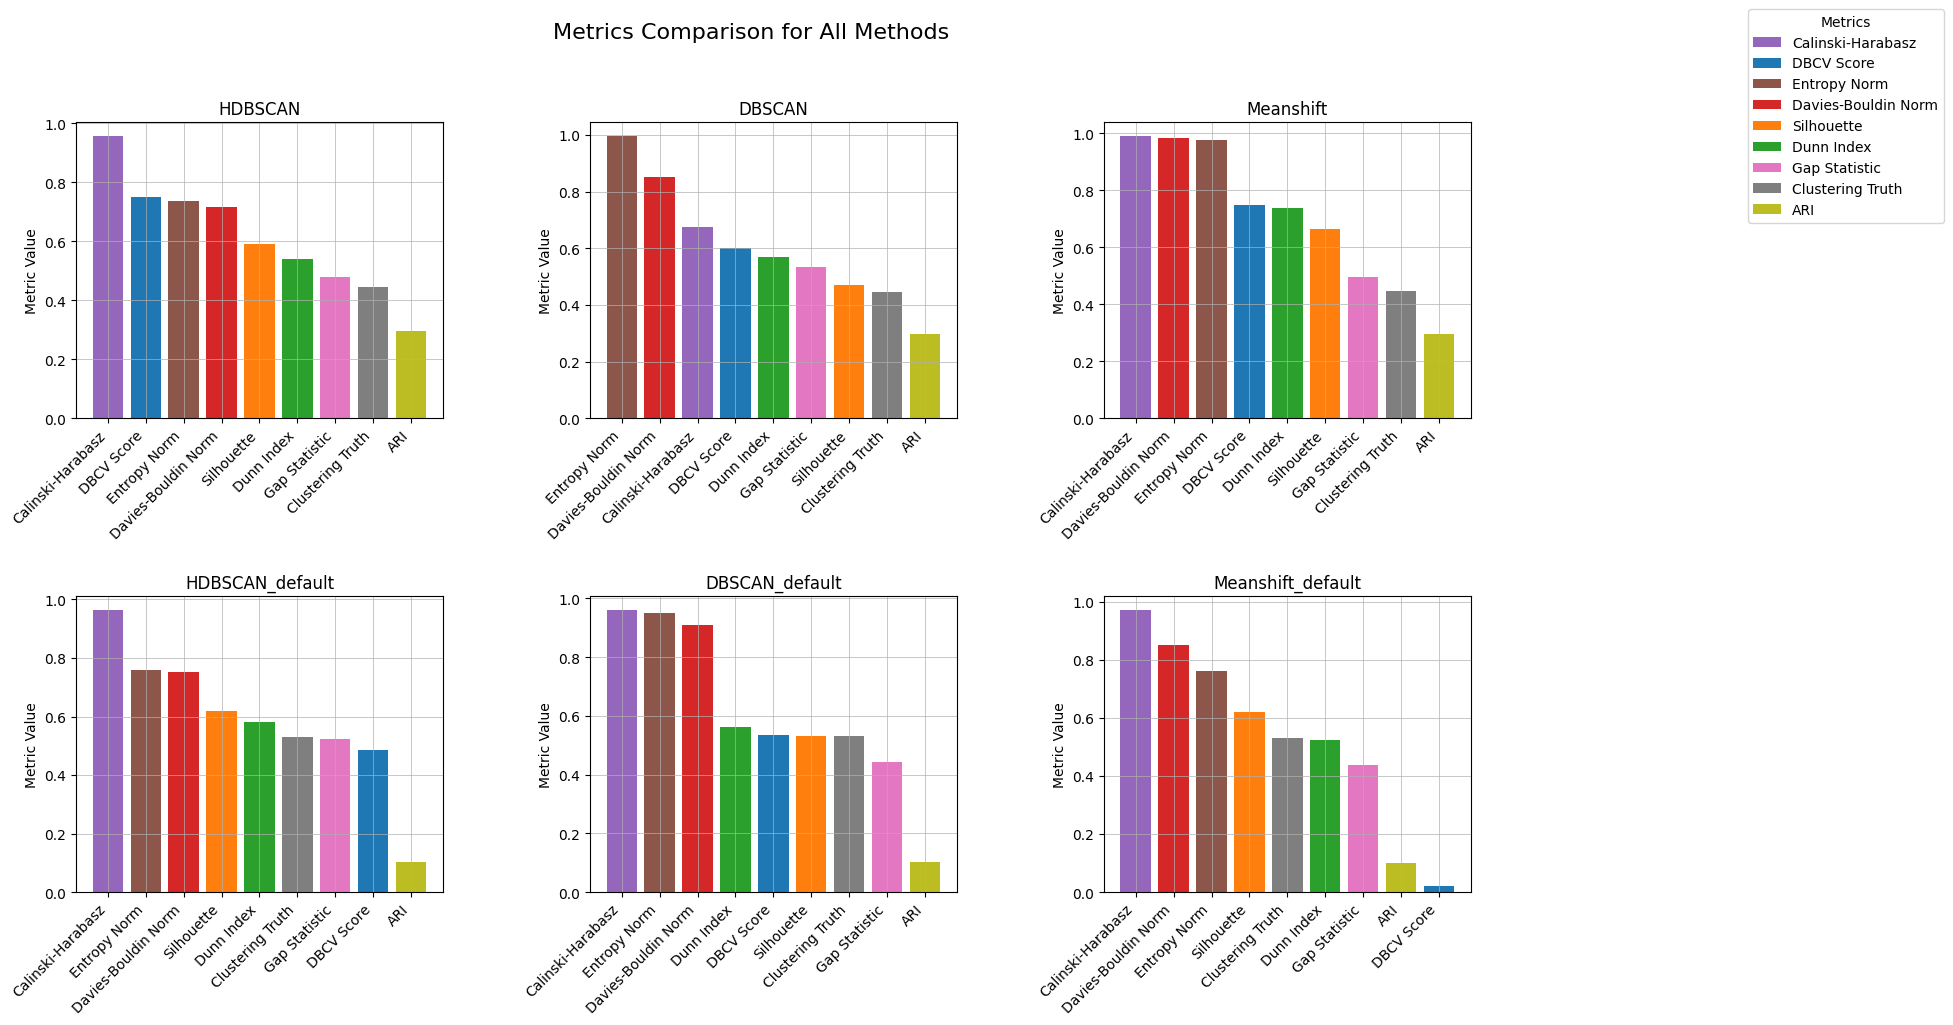

In [75]:
df_metrics_neuroblastoma.set_index("Method", inplace=True)

metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_neuroblastoma.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_neuroblastoma.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()


#**Diabetes**

In [134]:
diabetes = diabetes.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = diabetes.columns
scaler_minmax = MinMaxScaler()
diabetes_scaled = diabetes.copy()
diabetes_scaled[numerical_features] = scaler_minmax.fit_transform(diabetes[numerical_features])
diabetes_scaled.reset_index(drop=True, inplace=True)
diabetes_scaled.drop_duplicates(inplace=True)
df_metrics_diabetes = pd.DataFrame()
diabetes_scaled

age  duration.of.diabetes  body_mass_index       TDD     basal  \
0   0.370370              0.233333           0.1875  0.421053  0.209302   
1   0.370370              0.500000           0.4375  0.726316  0.531561   
2   0.407407              0.533333           0.1250  0.175940  0.348837   
3   0.148148              0.233333           0.1250  0.666165  0.468439   
4   0.666667              0.833333           0.8750  0.681203  0.707641   
..       ...                   ...              ...       ...       ...   
62  0.555556              0.600000           0.0000  0.470677  1.000000   
63  0.962963              0.800000           0.3750  0.184962  0.232558   
64  0.000000              0.166667           0.4375  0.846617  0.860465   
65  0.555556              0.633333           0.3125  0.275188  0.531561   
66  0.592593              0.533333           0.2500  0.293233  0.548173   

       bolus     HbA1c      eGFR  perc.body.fat  adiponectin  \
0   0.529101  0.214286  0.422018       0.971429     0.375000   
1   0.716049  0.482143  0.546527       0.980952     0.225694   
2   0.167549  0.125000  0.448231       0.971429     0.437500   
3   0.679012  0.375000  0.550459       0.971429     0.107639   
4   0.567901  0.446429  0.758847       0.990476     0.357639   
..       ...       ...       ...            ...          ...   
62  0.167549  0.732143  0.000000       0.971429     0.381944   
63  0.239859  0.321429  0.342071       0.980952     0.288194   
64  0.682540  0.500000  0.832241       0.971429     0.343750   
65  0.186949  0.303571  0.563565       0.971429     0.253472   
66  0.199295  0.089286  0.568807       0.971429     0.579861   

    free.testosterone       SMI  grip.strength  knee.extension.strength  \
0            0.022599  0.388889       0.358090                 0.312500   
1            0.531073  0.555556       0.607427                 0.542763   
2            0.039548  0.166667       0.042440                 0.312500   
3            0.050847  0.277778       0.381963                 0.299342   
4            0.542373  0.777778       0.671088                 0.500000   
..                ...       ...            ...                      ...   
62           0.016949  0.111111       0.209549                 0.542763   
63           0.276836  0.500000       0.233422                 0.154605   
64           0.954802  0.694444       0.612732                 0.572368   
65           0.429379  0.694444       1.000000                 0.674342   
66           0.220339  0.444444       0.026525                 0.161184   

    gait.speed      ucOC        OC  weight_kg  insulin_regimen_binary  \
0     0.000000  1.000000  1.000000   0.139482                     0.0   
1     0.583333  0.188172  0.254630   0.603659                     1.0   
2     0.333333  0.080645  0.101852   0.142683                     0.0   
3     0.500000  0.161290  0.187500   0.054878                     1.0   
4     0.416667  0.107527  0.134259   1.000000                     0.0   
..         ...       ...       ...        ...                     ...   
62    0.750000  0.838710  0.879630   0.000000                     1.0   
63    0.583333  0.086022  0.150463   0.164634                     1.0   
64    0.583333  0.424731  0.479167   0.457317                     1.0   
65    0.750000  0.231183  0.245370   0.384146                     1.0   
66    0.500000  0.000000  0.016204   0.213415                     0.0   

    sex_0man_1woman  
0               1.0  
1               0.0  
2               1.0  
3               1.0  
4               0.0  
..              ...  
62              1.0  
63              0.0  
64              0.0  
65              0.0  
66              1.0  

[67 rows x 20 columns]

**HDBSCAN**

In [135]:
min_size, epsilon= best_params_hdbscan(diabetes_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(diabetes_scaled)
labels_default = hdbscan_cluster_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels_default)
diabetes_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)


min_cluster_size: 6, cluster_selection_epsilon: 0.01


**DBSCAN**

In [136]:
min_sample, eps = best_params_dbscan(diabetes_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(diabetes_scaled)
labels_default = dbscan_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels_default)
diabetes_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [137]:
band = best_params_mean_shift(diabetes_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(diabetes_scaled)
labels_default = mean_shift_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels_default)
diabetes_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)
df_metrics_diabetes

Best bandwidth: 1.037


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.51        0.26    0.288354                 0.51   
1    HDBSCAN_default        0.66        0.39    0.462803                 0.83   
2             DBSCAN        0.09        0.03    0.106701                 0.95   
3     DBSCAN_default        0.00       -1.00   -1.000000                -1.00   
4          Meanshift        0.67        0.38    0.583365                 1.87   
5  Meanshift_default        0.48        0.47    0.317964                 1.51   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              20.11          0.10           1.23  
1              48.63          0.12           1.24  
2               7.05          0.57           1.31  
3              -1.00         -1.00           1.32  
4              35.31          1.04           1.36  
5              70.91          0.72           1.44

**Cluster Analysis**

In [138]:
cluster_similarity = similar_cluster(diabetes_scaled)
cluster_similarity.head()

[11  2  1  0  6  4  7  3  5  8 10  9]
[-1  0]
[-1  0  2  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
27           0      -1        1    32.835821
18           1      -1        2    23.880597
9            2      -1        0    22.388060
62           3       0        2     8.955224
0           11      -1       -1     1.492537

In [139]:
cluster_similarity_default = similar_cluster_default(diabetes_scaled)
cluster_similarity_default.head()

[6 2 1 0 3 4 5]
[-1]
[-1  0  2  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
15           0      -1        1    32.835821
10           1      -1        2    32.835821
5            2      -1        0    22.388060
16           3      -1       -1     7.462687
0            6      -1       -1     1.492537

In [140]:
diabetes_scaled["DBSCAN_pred"] = diabetes_scaled["DBSCAN_pred"].astype(object)
diabetes_scaled["HDBSCAN_pred"] = diabetes_scaled["HDBSCAN_pred"].astype(object)
diabetes_scaled["Mean_shift_pred"] = diabetes_scaled["Mean_shift_pred"].astype(object)

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 2, "HDBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'B'

diabetes_scaled.loc[diabetes_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

diabetes_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    diabetes_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0})
    .astype(int)
)

same_value_count = (diabetes_scaled["HDBSCAN_pred"] == diabetes_scaled["DBSCAN_pred"]) & \
                   (diabetes_scaled["DBSCAN_pred"] == diabetes_scaled["Mean_shift_pred"])

same_value_count_default = (diabetes_scaled["HDBSCAN_default_pred"] == diabetes_scaled["DBSCAN_default_pred"]) & \
                   (diabetes_scaled["DBSCAN_default_pred"] == diabetes_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(diabetes_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(diabetes_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(diabetes_scaled)

df_metrics_diabetes['Clustering Truth'] = df_metrics_diabetes['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_diabetes['ARI'] = df_metrics_diabetes['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_diabetes = df_metrics_diabetes.sort_values('DBCV Score', ascending=False)
df_metrics_diabetes

Totale delle righe con lo stesso valore: 28
Percentuale rispetto al totale: 41.79 %
Totale delle righe con lo stesso valore con parametri default: 22
Percentuale rispetto al totale: 32.84 %


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift        0.67        0.38    0.583365                 1.87   
1    HDBSCAN_default        0.66        0.39    0.462803                 0.83   
0            HDBSCAN        0.51        0.26    0.288354                 0.51   
5  Meanshift_default        0.48        0.47    0.317964                 1.51   
2             DBSCAN        0.09        0.03    0.106701                 0.95   
3     DBSCAN_default        0.00       -1.00   -1.000000                -1.00   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4              35.31          1.04           1.36             0.418  0.248090  
1              48.63          0.12           1.24             0.328  0.211424  
0              20.11          0.10           1.23             0.418  0.248090  
5              70.91          0.72           1.44             0.328  0.211424  
2               7.05          0.57           1.31             0.418  0.248090  
3              -1.00         -1.00           1.32             0.328  0.211424

In [143]:
df_metrics_diabetes["Silhouette"] = (df_metrics_diabetes["Silhouette"] + 1) / 2
df_metrics_diabetes["DBCV Score"] = (df_metrics_diabetes["DBCV Score"] + 1) / 2
df_metrics_diabetes["Dunn Index"] = (erf(df_metrics_diabetes["Dunn Index"]) + 1) / 2
df_metrics_diabetes["Davies-Bouldin Norm"] = (erf(df_metrics_diabetes["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_diabetes["Calinski-Harabasz"] = 1 - (1 / df_metrics_diabetes["Calinski-Harabasz"])
df_metrics_diabetes["Entropy Norm"] = (erf(df_metrics_diabetes["Entropy Norm"]) + 1) / 2
df_metrics_diabetes["Gap Statistic"] = (erf(df_metrics_diabetes["Gap Statistic"]) + 1) / 2

df_metrics_diabetes

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift       0.835       0.690    0.795315             0.995910   
1    HDBSCAN_default       0.830       0.695    0.743606             0.879762   
0            HDBSCAN       0.755       0.630    0.658288             0.764622   
5  Meanshift_default       0.740       0.735    0.673525             0.983638   
2             DBSCAN       0.545       0.515    0.559972             0.910445   
3     DBSCAN_default       0.500       0.000    0.078650             0.078650   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4           0.971679      0.929325       0.972781             0.418  0.248090  
1           0.979437      0.567379       0.960253             0.328  0.211424  
0           0.950273      0.556231       0.959025             0.418  0.248090  
5           0.985898      0.845717       0.979148             0.328  0.211424  
2           0.858156      0.789908       0.968032             0.418  0.248090  
3           2.000000      0.078650       0.969033             0.328  0.211424

In [144]:
distance_table_diabetes = df_metrics_diabetes.copy()

for metric in metrics:
    distance_table_diabetes[metric] = np.sqrt((df_metrics_diabetes[metric] - df_metrics_diabetes["Clustering Truth"]) ** 2)

distance_table_diabetes = distance_table_diabetes.sort_values(by="DBCV Score", ascending=True)
distance_table_diabetes.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_diabetes.columns
]
distance_table_diabetes

Method  DBCV Score Distance  Silhouette Distance  \
2             DBSCAN                0.127                0.097   
3     DBSCAN_default                0.172                0.328   
0            HDBSCAN                0.337                0.212   
5  Meanshift_default                0.412                0.407   
4          Meanshift                0.417                0.272   
1    HDBSCAN_default                0.502                0.367   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
2             0.141972                      0.492445   
3             0.249350                      0.249350   
0             0.240288                      0.346622   
5             0.345525                      0.655638   
4             0.377315                      0.577910   
1             0.415606                      0.551762   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
2                    0.440156               0.371908                0.550032   
3                    1.672000               0.249350                0.641033   
0                    0.532273               0.138231                0.541025   
5                    0.657898               0.517717                0.651148   
4                    0.553679               0.511325                0.554781   
1                    0.651437               0.239379                0.632253   

   Clustering Truth       ARI  
2             0.418  0.248090  
3             0.328  0.211424  
0             0.418  0.248090  
5             0.328  0.211424  
4             0.418  0.248090  
1             0.328  0.211424

**No Normalizzazione**

In [142]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_diabetes.columns:
            best_value = distance_table_diabetes.loc[distance_table_diabetes["Method"] == method, metric_value].values[0]
            default_value = distance_table_diabetes.loc[distance_table_diabetes["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_diabetes,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters    Default     Method trend  \
0                DBCV         0.328000   0.328000     DBSCAN     ↑   
1          Silhouette         0.388000   1.328000     DBSCAN     ↑   
2                Dunn         0.311299   1.328000     DBSCAN     ↑   
3      Davies-Bouldin         0.532000   1.328000     DBSCAN     ↑   
4   Calinski-Harabasz         6.632000   1.328000     DBSCAN     ↓   
5             Entropy         0.152000   1.328000     DBSCAN     ↑   
6                 Gap         0.892000   0.992000     DBSCAN     ↑   
7                DBCV         0.092000   0.332000    HDBSCAN     ↑   
8          Silhouette         0.158000   0.062000    HDBSCAN     ↓   
9                Dunn         0.129646   0.134803    HDBSCAN     ↑   
10     Davies-Bouldin         0.092000   0.502000    HDBSCAN     ↑   
11  Calinski-Harabasz        19.692000  48.302000    HDBSCAN     ↑   
12            Entropy         0.318000   0.208000    HDBSCAN     ↓   
13                Gap         0.812000   0.912000    HDBSCAN     ↑   
14               DBCV         0.252000   0.152000  Meanshift     ↓   
15         Silhouette         0.038000   0.142000  Meanshift     ↑   
16               Dunn         0.165365   0.010036  Meanshift     ↓   
17     Davies-Bouldin         1.452000   1.182000  Meanshift     ↓   
18  Calinski-Harabasz        34.892000  70.582000  Meanshift     ↑   
19            Entropy         0.622000   0.392000  Meanshift     ↓   
20                Gap         0.942000   1.112000  Meanshift     ↑   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                      Consistent  
3                      Consistent  
4                    Inconsistent  
5                      Consistent  
6                      Consistent  
7                      Consistent  
8                    Inconsistent  
9                      Consistent  
10                     Consistent  
11                     Consistent  
12                   Inconsistent  
13                     Consistent  
14                   Inconsistent  
15                     Consistent  
16                   Inconsistent  
17                   Inconsistent  
18                     Consistent  
19                   Inconsistent  
20                     Consistent

**Normalizzazione**

In [145]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_diabetes.columns:
            best_value = distance_table_diabetes.loc[distance_table_diabetes["Method"] == method, metric_value].values[0]
            default_value = distance_table_diabetes.loc[distance_table_diabetes["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_diabetes,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.127000  0.172000     DBSCAN     ↑   
1          Silhouette         0.097000  0.328000     DBSCAN     ↑   
2                Dunn         0.141972  0.249350     DBSCAN     ↑   
3      Davies-Bouldin         0.492445  0.249350     DBSCAN     ↓   
4   Calinski-Harabasz         0.440156  1.672000     DBSCAN     ↑   
5             Entropy         0.371908  0.249350     DBSCAN     ↓   
6                 Gap         0.550032  0.641033     DBSCAN     ↑   
7                DBCV         0.337000  0.502000    HDBSCAN     ↑   
8          Silhouette         0.212000  0.367000    HDBSCAN     ↑   
9                Dunn         0.240288  0.415606    HDBSCAN     ↑   
10     Davies-Bouldin         0.346622  0.551762    HDBSCAN     ↑   
11  Calinski-Harabasz         0.532273  0.651437    HDBSCAN     ↑   
12            Entropy         0.138231  0.239379    HDBSCAN     ↑   
13                Gap         0.541025  0.632253    HDBSCAN     ↑   
14               DBCV         0.417000  0.412000  Meanshift     ↓   
15         Silhouette         0.272000  0.407000  Meanshift     ↑   
16               Dunn         0.377315  0.345525  Meanshift     ↓   
17     Davies-Bouldin         0.577910  0.655638  Meanshift     ↑   
18  Calinski-Harabasz         0.553679  0.657898  Meanshift     ↑   
19            Entropy         0.511325  0.517717  Meanshift     ↑   
20                Gap         0.554781  0.651148  Meanshift     ↑   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                      Consistent  
3                    Inconsistent  
4                      Consistent  
5                    Inconsistent  
6                      Consistent  
7                      Consistent  
8                      Consistent  
9                      Consistent  
10                     Consistent  
11                     Consistent  
12                     Consistent  
13                     Consistent  
14                   Inconsistent  
15                     Consistent  
16                   Inconsistent  
17                     Consistent  
18                     Consistent  
19                     Consistent  
20                     Consistent

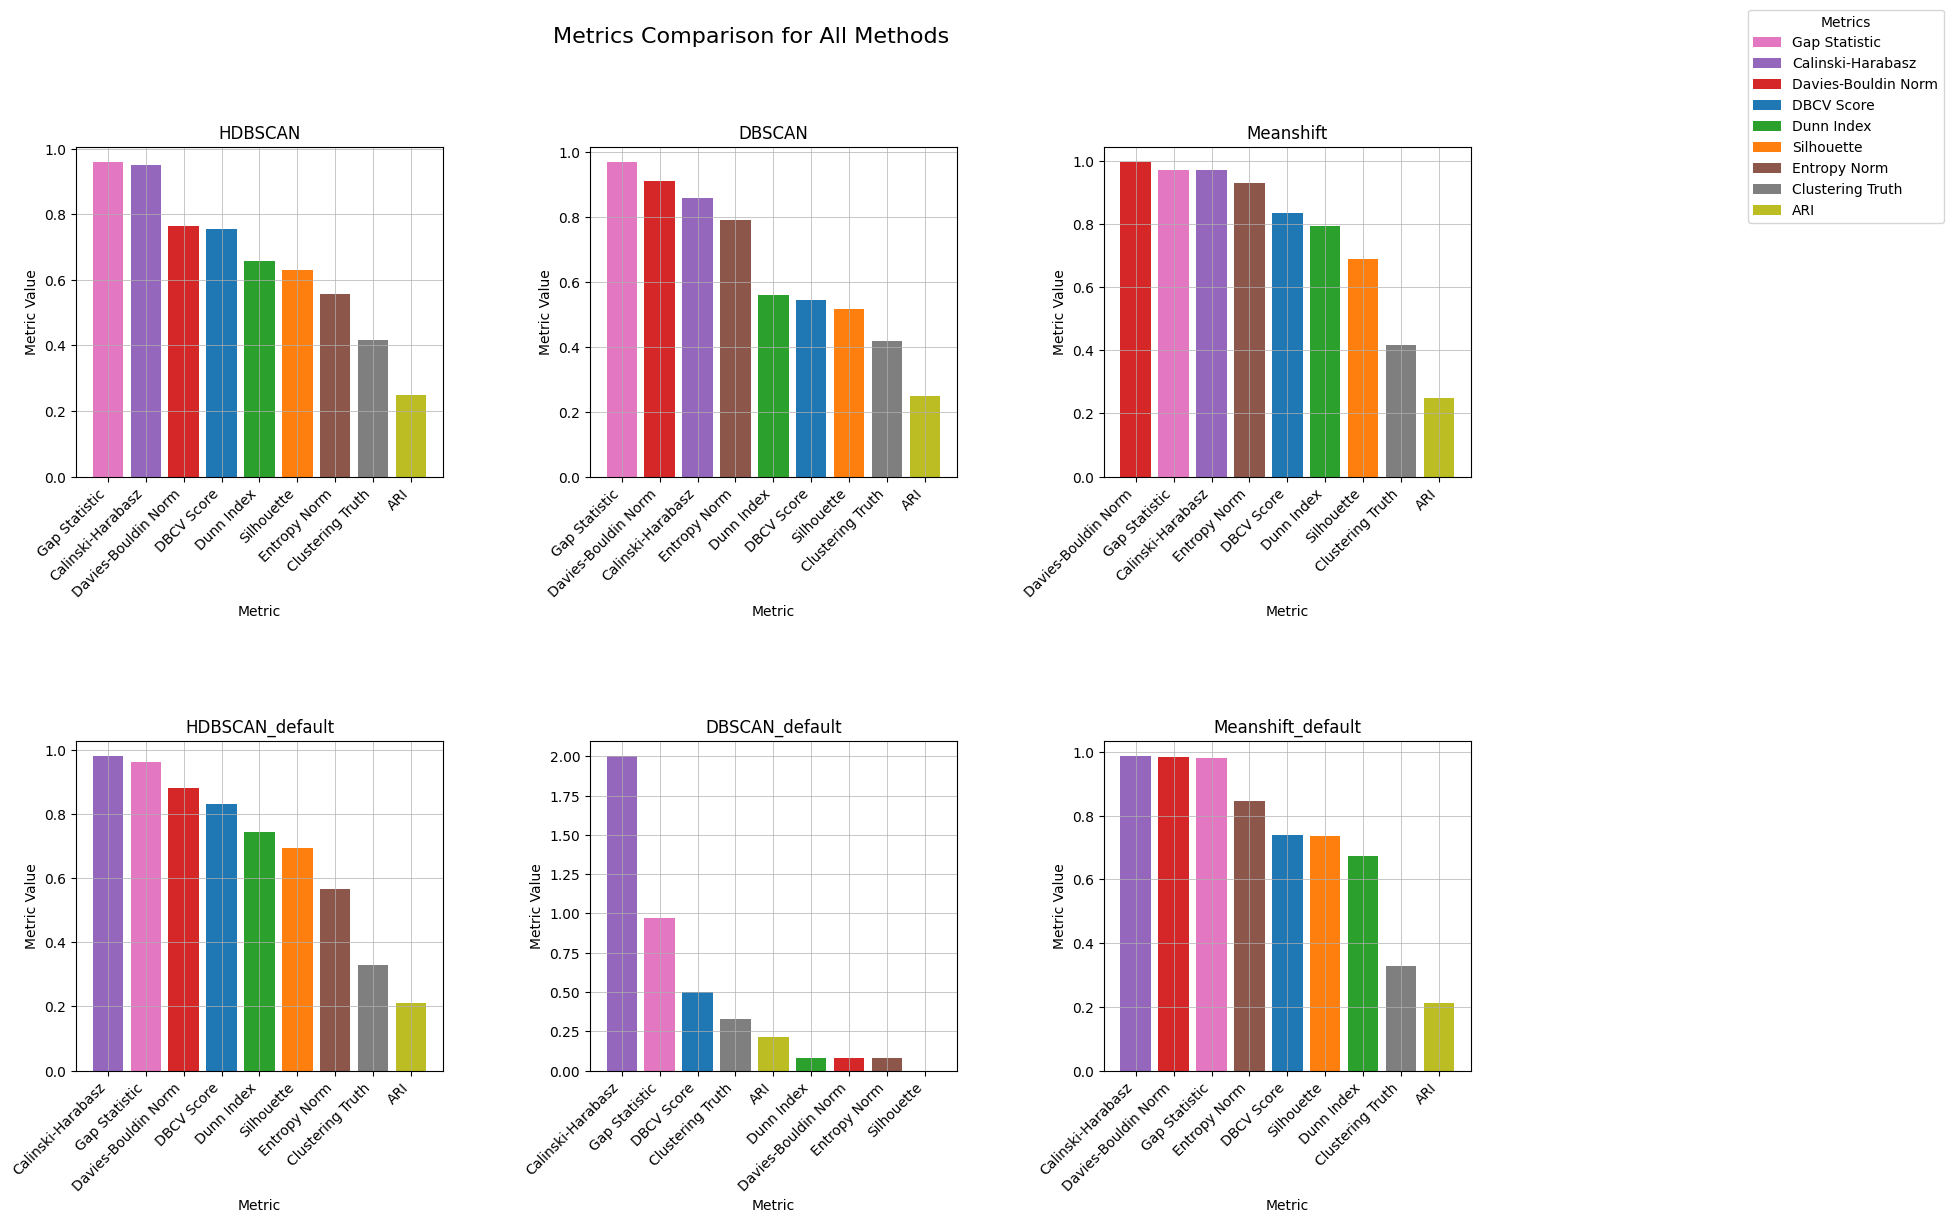

In [146]:
df_metrics_diabetes.set_index("Method", inplace=True)

methods = df_metrics_diabetes.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_diabetes.columns)}
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_diabetes.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#**Sepsis**

In [147]:
sepsis = sepsis.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = sepsis.columns
scaler_minmax = MinMaxScaler()
sepsis_scaled = sepsis.copy()
sepsis_scaled[numerical_features] = scaler_minmax.fit_transform(sepsis_scaled[numerical_features])
sepsis_scaled.reset_index(drop=True, inplace=True)
sepsis_scaled.drop_duplicates(inplace=True)
df_metrics_sepsis = pd.DataFrame()
sepsis_scaled

Age  sex_woman  diagnosis_0EC_1M_2_AC  APACHE II    SOFA       CRP  \
0     0.061728        0.0                    1.0   0.291667  0.0000  0.000384   
1     0.432099        0.0                    1.0   0.208333  0.1875  0.172911   
2     0.802469        0.0                    1.0   0.166667  0.2500  0.228818   
3     0.209877        0.0                    1.0   0.062500  0.0000  0.141787   
4     0.839506        0.0                    1.0   0.354167  0.1250  0.095485   
...        ...        ...                    ...        ...     ...       ...   
1252  0.814815        1.0                    0.5   0.375000  0.1875  0.005764   
1253  0.148148        1.0                    0.5   0.062500  0.0000  0.001921   
1254  0.543210        1.0                    0.5   0.395833  0.3750  0.086455   
1255  0.160494        1.0                    0.5   0.333333  0.3125  0.038425   
1256  0.395062        0.0                    0.5   0.104167  0.0625  0.125456   

          WBCC      NeuC      LymC       EOC      NLCR      PLTC       MPV  \
0     0.195721  0.168191  0.174444  0.097561  0.015703  0.195730  0.093458   
1     0.367670  0.319682  0.088299  0.000000  0.061385  0.319098  0.100935   
2     0.237718  0.193042  0.102656  0.000000  0.031644  0.103203  0.085981   
3     0.140650  0.114712  0.134243  0.048780  0.014038  0.288256  0.073832   
4     0.198891  0.189463  0.111271  0.000000  0.028551  0.144721  0.110280   
...        ...       ...       ...       ...       ...       ...       ...   
1252  0.121038  0.100596  0.115578  0.073171  0.014276  0.158956  0.090654   
1253  0.144414  0.064215  0.497487  0.073171  0.001190  0.304864  0.096262   
1254  0.077060  0.066203  0.043790  0.048780  0.025934  0.209964  0.080374   
1255  0.154517  0.129026  0.108399  0.048780  0.019748  0.181495  0.084112   
1256  0.217512  0.192247  0.128500  0.000000  0.024982  0.213523  0.089720   

      Group   LOS-ICU  Mortality  
0       0.0  0.000000        0.0  
1       0.0  0.000000        0.0  
2       0.0  0.000000        0.0  
3       0.0  0.000000        0.0  
4       0.0  0.000000        0.0  
...     ...       ...        ...  
1252    0.0  0.052632        0.0  
1253    0.0  0.000000        0.0  
1254    0.0  0.147368        0.0  
1255    1.0  0.031579        0.0  
1256    0.0  0.000000        0.0  

[1257 rows x 16 columns]

**HDBSCAN**

In [148]:
min_size, epsilon= best_params_hdbscan(sepsis_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(sepsis_scaled)
labels_default = hdbscan_cluster_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels_default)
sepsis_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)


min_cluster_size: 6, cluster_selection_epsilon: 0.01


**DBSCAN**

In [149]:
min_sample, eps = best_params_dbscan(sepsis_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(sepsis_scaled)
labels_default = dbscan_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels_default)
sepsis_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [150]:
band = best_params_mean_shift(sepsis_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(sepsis_scaled)
labels_default = mean_shift_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels_default)
sepsis_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)
df_metrics_sepsis

Best bandwidth: 3.032


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.40        0.31    0.096830                 0.64   
1    HDBSCAN_default        0.35        0.46    0.025004                 0.76   
2             DBSCAN        0.82        0.58    0.039535                 0.92   
3     DBSCAN_default        0.89        0.81    0.013057                 2.52   
4          Meanshift        0.90        0.85    0.377478                 3.84   
5  Meanshift_default       -0.55        0.57    0.231504                 1.68   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0             286.31          0.59           1.86  
1             816.52          0.61           1.78  
2            1762.81          0.80           1.58  
3            1772.17          0.57           1.22  
4            9417.62          1.00           1.32  
5             804.23          0.89           1.24

**Cluster Analysis**

In [153]:
cluster_similarity = similar_cluster(sepsis_scaled)
cluster_similarity

[14 12  6 13 17 11  0  9  1 10  3  2  7 20 16 18  4  8 15  5 19]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 14 13 15]
[-1  5  2  6  4  0 10 11  8  3  9 12  1  7]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
1490           0       3       10    25.934765
1996           1       5        8    16.070008
2755           2       8       12    11.296738
2502           3       7        9     8.353222
4003           4      12        7     7.398568
...          ...     ...      ...          ...
1671           9      -1        0     0.000000
1670           9      -1        4     0.000000
1669           9      -1        6     0.000000
1668           9      -1        2     0.000000
4997          19      15        7     0.000000

[4998 rows x 4 columns]

In [152]:
cluster_similarity_default = similar_cluster_default(sepsis_scaled)
cluster_similarity_default

[2 0 3 4 1]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 4 -1  2  7  0  6 10  9 12  5 11  1  8  3 13]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
260            0       2        6    25.934765
292            0       4        9    16.070008
340            0       7       11    11.296738
324            0       6        5     8.353222
1017           1      10        8     7.398568
...          ...     ...      ...          ...
369            0       9        5     0.000000
370            0       9       11     0.000000
371            0       9        1     0.000000
372            0       9        8     0.000000
525            3       6        4     0.000000

[1050 rows x 4 columns]

In [155]:
sepsis_scaled["DBSCAN_pred"] = sepsis_scaled["DBSCAN_pred"].astype(object)
sepsis_scaled["HDBSCAN_pred"] = sepsis_scaled["HDBSCAN_pred"].astype(object)
sepsis_scaled["Mean_shift_pred"] = sepsis_scaled["Mean_shift_pred"].astype(object)

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 10, "HDBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 12, "HDBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 9, "HDBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'D'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 7, "HDBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'E'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 15, "DBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'F'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'G'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 10, "DBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'H'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'I'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'I'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'I'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 6, "DBSCAN_pred"] = 'J'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'J'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 10, "Mean_shift_pred"] = 'J'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'K'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 5, "HDBSCAN_pred"] = 'K'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 12, "Mean_shift_pred"] = 'K'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 4, "DBSCAN_pred"] = 'L'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 11, "HDBSCAN_pred"] = 'L'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 9, "Mean_shift_pred"] = 'L'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 2, "DBSCAN_default_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 6, "HDBSCAN_default_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 10, "DBSCAN_default_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 8, "HDBSCAN_default_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 9, "DBSCAN_default_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 3, "Mean_shift_default_pred"] = 'D'

sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,
              'J': 9,'K': 10,'L': 11,})
    .astype(int)
)

sepsis_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    sepsis_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3})
    .astype(int)
)

same_value_count = (sepsis_scaled["HDBSCAN_pred"] == sepsis_scaled["DBSCAN_pred"]) & \
                   (sepsis_scaled["DBSCAN_pred"] == sepsis_scaled["Mean_shift_pred"])

same_value_count_default = (sepsis_scaled["HDBSCAN_default_pred"] == sepsis_scaled["DBSCAN_default_pred"]) & \
                   (sepsis_scaled["DBSCAN_default_pred"] == sepsis_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(sepsis_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(sepsis_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(sepsis_scaled)

df_metrics_sepsis['Clustering Truth'] = df_metrics_sepsis['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_sepsis['ARI'] = df_metrics_sepsis['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_sepsis = df_metrics_sepsis.sort_values('DBCV Score', ascending=False)
df_metrics_sepsis

Totale delle righe con lo stesso valore: 1138
Percentuale rispetto al totale: 90.53 %
Totale delle righe con lo stesso valore con parametri default: 548
Percentuale rispetto al totale: 43.6 %


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift        0.90        0.85    0.377478                 3.84   
3     DBSCAN_default        0.89        0.81    0.013057                 2.52   
2             DBSCAN        0.82        0.58    0.039535                 0.92   
0            HDBSCAN        0.40        0.31    0.096830                 0.64   
1    HDBSCAN_default        0.35        0.46    0.025004                 0.76   
5  Meanshift_default       -0.55        0.57    0.231504                 1.68   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4            9417.62          1.00           1.32             0.905  0.934985  
3            1772.17          0.57           1.22             0.436  0.438418  
2            1762.81          0.80           1.58             0.905  0.934985  
0             286.31          0.59           1.86             0.905  0.934985  
1             816.52          0.61           1.78             0.436  0.438418  
5             804.23          0.89           1.24             0.436  0.438418

In [158]:
df_metrics_sepsis["Silhouette"] = (df_metrics_sepsis["Silhouette"] + 1) / 2
df_metrics_sepsis["DBCV Score"] = (df_metrics_sepsis["DBCV Score"] + 1) / 2
df_metrics_sepsis["Dunn Index"] = (erf(df_metrics_sepsis["Dunn Index"]) + 1) / 2
df_metrics_sepsis["Davies-Bouldin Norm"] = (erf(df_metrics_sepsis["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_sepsis["Calinski-Harabasz"] = 1 - (1 / df_metrics_sepsis["Calinski-Harabasz"])
df_metrics_sepsis["Entropy Norm"] = (erf(df_metrics_sepsis["Entropy Norm"]) + 1) / 2
df_metrics_sepsis["Gap Statistic"] = (erf(df_metrics_sepsis["Gap Statistic"]) + 1) / 2
df_metrics_sepsis

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift       0.950       0.925    0.703272             1.000000   
3     DBSCAN_default       0.945       0.905    0.507366             0.999817   
2             DBSCAN       0.910       0.790    0.522293             0.903384   
0            HDBSCAN       0.700       0.655    0.554460             0.817293   
1    HDBSCAN_default       0.675       0.730    0.514104             0.858768   
5  Meanshift_default       0.225       0.785    0.628316             0.991246   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4           0.999894      0.921350       0.969033             0.905  0.934985  
3           0.999436      0.789908       0.957767             0.436  0.438418  
2           0.999433      0.871050       0.987274             0.905  0.934985  
0           0.996507      0.797968       0.995736             0.905  0.934985  
1           0.998775      0.805841       0.994087             0.436  0.438418  
5           0.998757      0.895922       0.960253             0.436  0.438418

In [159]:
distance_table_sepsis = df_metrics_sepsis.copy()

for metric in metrics:
    distance_table_sepsis[metric] = np.sqrt((df_metrics_sepsis[metric] - df_metrics_sepsis["Clustering Truth"]) ** 2)
distance_table_sepsis = distance_table_sepsis.sort_values(by="DBCV Score", ascending=True)
distance_table_sepsis.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_sepsis.columns
]
distance_table_sepsis

Method  DBCV Score Distance  Silhouette Distance  \
2             DBSCAN                0.005                0.115   
4          Meanshift                0.045                0.020   
0            HDBSCAN                0.205                0.250   
5  Meanshift_default                0.211                0.349   
1    HDBSCAN_default                0.239                0.294   
3     DBSCAN_default                0.509                0.469   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
2             0.382707                      0.001616   
4             0.201728                      0.095000   
0             0.350540                      0.087707   
5             0.192316                      0.555246   
1             0.078104                      0.422768   
3             0.071366                      0.563817   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
2                    0.094433               0.033950                0.082274   
4                    0.094894               0.016350                0.064033   
0                    0.091507               0.107032                0.090736   
5                    0.562757               0.459922                0.524253   
1                    0.562775               0.369841                0.558087   
3                    0.563436               0.353908                0.521767   

   Clustering Truth       ARI  
2             0.905  0.934985  
4             0.905  0.934985  
0             0.905  0.934985  
5             0.436  0.438418  
1             0.436  0.438418  
3             0.436  0.438418

**No normalizzazione**

In [157]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_sepsis.columns:
            best_value = distance_table_sepsis.loc[distance_table_sepsis["Method"] == method, metric_value].values[0]
            default_value = distance_table_sepsis.loc[distance_table_sepsis["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_sepsis,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters      Default     Method trend  \
0                DBCV         0.085000     0.454000     DBSCAN     ↑   
1          Silhouette         0.325000     0.374000     DBSCAN     ↑   
2                Dunn         0.865465     0.422943     DBSCAN     ↓   
3      Davies-Bouldin         0.015000     2.084000     DBSCAN     ↑   
4   Calinski-Harabasz      1761.905000  1771.734000     DBSCAN     ↑   
5             Entropy         0.105000     0.134000     DBSCAN     ↑   
6                 Gap         0.675000     0.784000     DBSCAN     ↑   
7                DBCV         0.505000     0.086000    HDBSCAN     ↓   
8          Silhouette         0.595000     0.024000    HDBSCAN     ↓   
9                Dunn         0.808170     0.410996    HDBSCAN     ↓   
10     Davies-Bouldin         0.265000     0.324000    HDBSCAN     ↑   
11  Calinski-Harabasz       285.405000   816.084000    HDBSCAN     ↑   
12            Entropy         0.315000     0.174000    HDBSCAN     ↓   
13                Gap         0.955000     1.344000    HDBSCAN     ↑   
14               DBCV         0.005000     0.986000  Meanshift     ↑   
15         Silhouette         0.055000     0.134000  Meanshift     ↑   
16               Dunn         0.527522     0.204496  Meanshift     ↓   
17     Davies-Bouldin         2.935000     1.244000  Meanshift     ↓   
18  Calinski-Harabasz      9416.715000   803.794000  Meanshift     ↓   
19            Entropy         0.095000     0.454000  Meanshift     ↑   
20                Gap         0.415000     0.804000  Meanshift     ↑   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                    Inconsistent  
3                      Consistent  
4                      Consistent  
5                      Consistent  
6                      Consistent  
7                    Inconsistent  
8                    Inconsistent  
9                    Inconsistent  
10                     Consistent  
11                     Consistent  
12                   Inconsistent  
13                     Consistent  
14                     Consistent  
15                     Consistent  
16                   Inconsistent  
17                   Inconsistent  
18                   Inconsistent  
19                     Consistent  
20                     Consistent

**Normalizzazione**

In [160]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_sepsis.columns:
            best_value = distance_table_sepsis.loc[distance_table_sepsis["Method"] == method, metric_value].values[0]
            default_value = distance_table_sepsis.loc[distance_table_sepsis["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_sepsis,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.005000  0.509000     DBSCAN     ↑   
1          Silhouette         0.115000  0.469000     DBSCAN     ↑   
2                Dunn         0.382707  0.071366     DBSCAN     ↓   
3      Davies-Bouldin         0.001616  0.563817     DBSCAN     ↑   
4   Calinski-Harabasz         0.094433  0.563436     DBSCAN     ↑   
5             Entropy         0.033950  0.353908     DBSCAN     ↑   
6                 Gap         0.082274  0.521767     DBSCAN     ↑   
7                DBCV         0.205000  0.239000    HDBSCAN     ↑   
8          Silhouette         0.250000  0.294000    HDBSCAN     ↑   
9                Dunn         0.350540  0.078104    HDBSCAN     ↓   
10     Davies-Bouldin         0.087707  0.422768    HDBSCAN     ↑   
11  Calinski-Harabasz         0.091507  0.562775    HDBSCAN     ↑   
12            Entropy         0.107032  0.369841    HDBSCAN     ↑   
13                Gap         0.090736  0.558087    HDBSCAN     ↑   
14               DBCV         0.045000  0.211000  Meanshift     ↑   
15         Silhouette         0.020000  0.349000  Meanshift     ↑   
16               Dunn         0.201728  0.192316  Meanshift     ↓   
17     Davies-Bouldin         0.095000  0.555246  Meanshift     ↑   
18  Calinski-Harabasz         0.094894  0.562757  Meanshift     ↑   
19            Entropy         0.016350  0.459922  Meanshift     ↑   
20                Gap         0.064033  0.524253  Meanshift     ↑   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                    Inconsistent  
3                      Consistent  
4                      Consistent  
5                      Consistent  
6                      Consistent  
7                      Consistent  
8                      Consistent  
9                    Inconsistent  
10                     Consistent  
11                     Consistent  
12                     Consistent  
13                     Consistent  
14                     Consistent  
15                     Consistent  
16                   Inconsistent  
17                     Consistent  
18                     Consistent  
19                     Consistent  
20                     Consistent

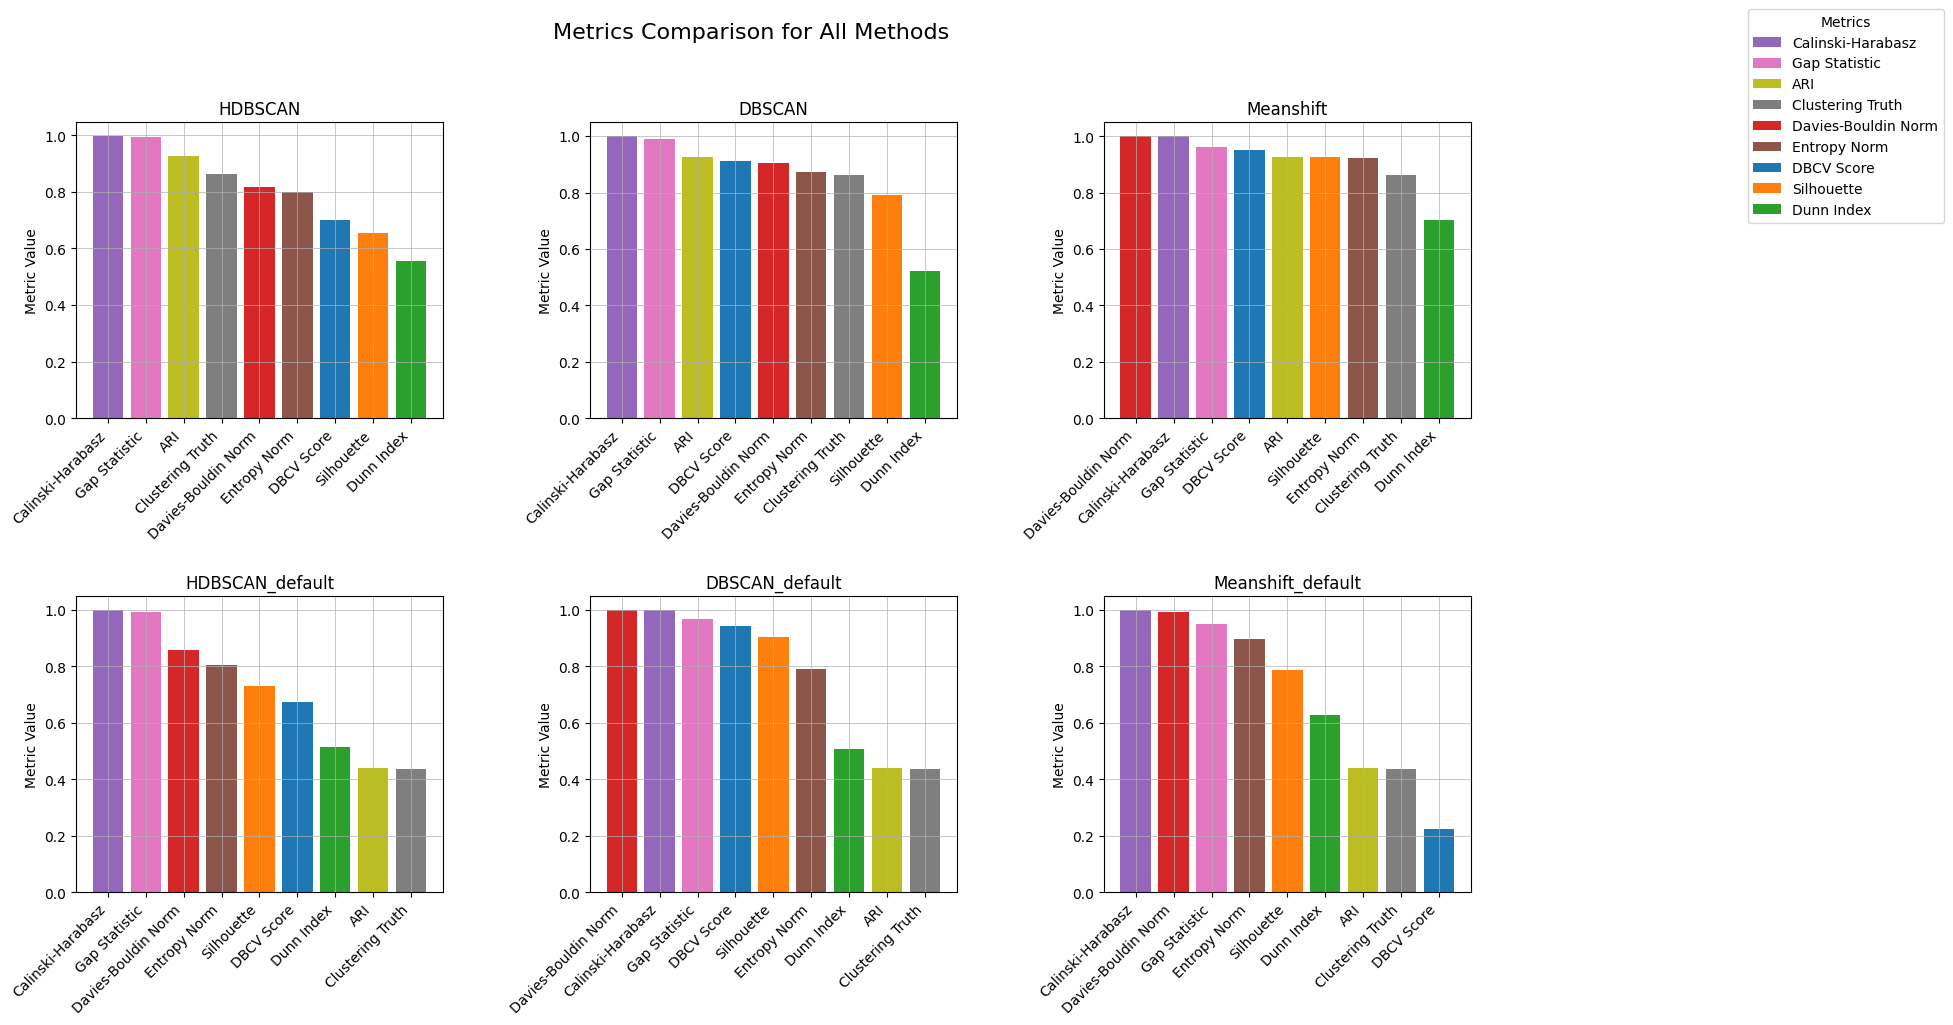

In [97]:
df_metrics_sepsis.set_index("Method", inplace=True)

methods = df_metrics_sepsis.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_sepsis.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_sepsis.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()


#**Heart failure**

In [161]:
heart_failure = heart_failure.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = heart_failure.columns
scaler_minmax = MinMaxScaler()
heart_failure_scaled = heart_failure.copy()
heart_failure_scaled[numerical_features] = scaler_minmax.fit_transform(heart_failure_scaled[numerical_features])
heart_failure_scaled.reset_index(drop=True, inplace=True)
heart_failure_scaled.drop_duplicates(inplace=True)
df_metrics_heart_failure = pd.DataFrame()
heart_failure_scaled

Age (years)  Male (1=Yes, 0=No)  PHQ-9  Systolic BP (mm Hg)  \
0       0.923077                 0.0   0.04             0.540000   
1       1.000000                 1.0   0.32             0.340000   
2       0.794872                 1.0   0.16             0.380000   
3       0.833333                 1.0   0.16             0.326667   
4       0.807692                 1.0   0.12             0.520000   
..           ...                 ...    ...                  ...   
420     0.371795                 1.0   0.12             0.526667   
421     0.666667                 1.0   0.44             0.606667   
422     0.538462                 1.0   0.68             0.473333   
423     0.346154                 1.0   0.16             0.720000   
424     0.423077                 0.0   1.00             0.466667   

     Estimated glomerular filtration rate  Ejection fraction (%)  \
0                                0.253775               0.695035   
1                                0.169680               0.758865   
2                                0.325089               0.758865   
3                                0.360210               0.297872   
4                                0.324216               0.659574   
..                                    ...                    ...   
420                              0.457364               0.539007   
421                              0.148905               0.659574   
422                              0.673790               0.225532   
423                              0.331913               0.075603   
424                              0.218280               0.617021   

     Serum sodium (mmol/l)  Blood urea nitrogen (mg/dl)  \
0                 0.500000                     0.218487   
1                 0.636364                     0.630252   
2                 0.681818                     0.235294   
3                 0.681818                     0.394958   
4                 0.500000                     0.268908   
..                     ...                          ...   
420               0.500000                     0.226891   
421               0.590909                     0.352941   
422               0.181818                     0.142857   
423               0.636364                     0.285714   
424               0.681818                     0.647059   

     Etiology HF(1=Yes, 0=No)  Prior diabetes mellitus  \
0                         1.0                      1.0   
1                         1.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      1.0   
4                         0.0                      1.0   
..                        ...                      ...   
420                       1.0                      1.0   
421                       0.0                      0.0   
422                       0.0                      1.0   
423                       0.0                      0.0   
424                       0.0                      1.0   

     Elevated level of BNP/NT-BNP (1=Yes, 0=No)  Time from HF to Death (days)  \
0                                           1.0                      0.929655   
1                                           1.0                      0.095172   
2                                           1.0                      1.000000   
3                                           1.0                      1.000000   
4                                           1.0                      1.000000   
..                                          ...                           ...   
420                                         1.0                      1.000000   
421                                         1.0                      1.000000   
422                                         1.0                      0.459310   
423                                         1.0                      1.000000   
424                                         1.0                      0.950

**HDBSCAN**

In [162]:
min_size, epsilon= best_params_hdbscan(heart_failure_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(heart_failure_scaled)
labels_default = hdbscan_cluster_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels_default)
heart_failure_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.01


**DBSCAN**

In [163]:
min_sample, eps = best_params_dbscan(heart_failure_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(heart_failure_scaled)
labels_default = dbscan_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels_default)
heart_failure_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [164]:
band = best_params_mean_shift(heart_failure_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(heart_failure_scaled)
labels_default = mean_shift_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels_default)
heart_failure_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)
df_metrics_heart_failure

Banda 17.61320049331573 genera solo un cluster. Ignorato.
Banda 19.02225653278099 genera solo un cluster. Ignorato.
Best bandwidth: 6.341


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.64        0.36    0.143838                 0.78   
1    HDBSCAN_default        0.67        0.36    0.014317                 0.67   
2             DBSCAN        0.60        0.18    0.012294                 0.62   
3     DBSCAN_default        0.52        0.18    0.007304                 0.69   
4          Meanshift        0.11        0.62    0.174758                 2.02   
5  Meanshift_default       -0.97        0.39    0.065316                 1.07   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              37.61          0.35           0.44  
1              76.78          0.43          -0.03  
2              36.50          1.01          -0.33  
3              26.70          1.18          -2.06  
4             418.24          0.88          -2.42  
5             232.08          0.37          -2.82

**Cluster Analysis**

In [166]:
cluster_similarity = similar_cluster(heart_failure_scaled)
cluster_similarity

[ 2  1  0 21 12 11 23  5  6 13 19  9  8  7 20  3 15  4 10 16 14 22 18 24
 17 25 26]
[-1  0  1  2  3  4  5  6 17  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22
 23 24 26 25 27 28 29 30]
[10 -1 24 14 33  6  8 25 31  0 22 27 28 12 18 23  9 20 26 30 11 19 35 17
  4  5 34 29  1 13 36 16 15  2  3 32 21  7]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
1217            1      -1       -1     9.411765
2472            0       0       24     7.058824
2629            0       4       25     5.647059
21496           4      20       34     4.941176
10122           6       8       18     4.235294
...           ...     ...      ...          ...
10960          13      -1        9     0.000000
10959          13      -1       23     0.000000
10958          13      -1       18     0.000000
10957          13      -1       12     0.000000
32831          26      30        7     0.000000

[32832 rows x 4 columns]

In [103]:
cluster_similarity_default = similar_cluster_default(heart_failure_scaled)
cluster_similarity_default

[0 1 2]
[-1  0  1 16  4 17  2  3 15  5  6  7  8  9 10 18 11 12 13 14]
[-1 14  6  1  3 15 23 12 17 21  5 10 13  2 18 24  4  9 19  8  0 16 22 20
  7 11]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0              0      -1       -1    18.352941
547            1       0       14     5.882353
629            1       4       15     5.647059
957            1      11       16     4.941176
739            1      15       10     4.235294
...          ...     ...      ...          ...
524            1      -1        3     0.000000
523            1      -1        1     0.000000
522            1      -1        6     0.000000
519            0      14       11     0.000000
1559           2      14       11     0.000000

[1560 rows x 4 columns]

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [167]:
heart_failure_scaled["DBSCAN_pred"] = heart_failure_scaled["DBSCAN_pred"].astype(object)
heart_failure_scaled["HDBSCAN_pred"] = heart_failure_scaled["HDBSCAN_pred"].astype(object)
heart_failure_scaled["Mean_shift_pred"] = heart_failure_scaled["Mean_shift_pred"].astype(object)

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 24, "HDBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 20, "DBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 34, "HDBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'C'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 18, "HDBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'D'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'E'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 35, "HDBSCAN_pred"] = 'E'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'E'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'F'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 19, "HDBSCAN_pred"] = 'F'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'F'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 18, "DBSCAN_pred"] = 'G'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 30, "HDBSCAN_pred"] = 'G'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'G'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'H'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 14, "HDBSCAN_pred"] = 'H'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'H'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'I'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 11, "HDBSCAN_pred"] = 'I'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'I'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 11, "DBSCAN_pred"] = 'J'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 26, "HDBSCAN_pred"] = 'J'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 13, "Mean_shift_pred"] = 'J'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'K'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 31, "HDBSCAN_pred"] = 'K'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 11, "Mean_shift_pred"] = 'K'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 26, "DBSCAN_pred"] = 'L'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 36, "HDBSCAN_pred"] = 'L'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 14, "Mean_shift_pred"] = 'L'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'M'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'M'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 12, "Mean_shift_pred"] = 'M'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 19, "DBSCAN_pred"] = 'N'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 17, "HDBSCAN_pred"] = 'N'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 15, "Mean_shift_pred"] = 'N'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 29, "DBSCAN_pred"] = 'O'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 21, "HDBSCAN_pred"] = 'O'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 17, "Mean_shift_pred"] = 'O'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 23, "DBSCAN_pred"] = 'P'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 13, "HDBSCAN_pred"] = 'P'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 16, "Mean_shift_pred"] = 'P'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 10, "DBSCAN_pred"] = 'Q'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 20, "HDBSCAN_pred"] = 'Q'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 19, "Mean_shift_pred"] = 'Q'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == 0, "DBSCAN_default_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == 14, "HDBSCAN_default_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == 13, "DBSCAN_default_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,
              'J': 9,'K': 10,'L': 11,'M': 12,'N': 13,'O': 14,'P': 15,'Q':16})
    .astype(int)
)

heart_failure_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    heart_failure_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C':2})
    .astype(int)
)

same_value_count = (heart_failure_scaled["HDBSCAN_pred"] == heart_failure_scaled["DBSCAN_pred"]) & \
                   (heart_failure_scaled["DBSCAN_pred"] == heart_failure_scaled["Mean_shift_pred"])

same_value_count_default = (heart_failure_scaled["HDBSCAN_default_pred"] == heart_failure_scaled["DBSCAN_default_pred"]) & \
                   (heart_failure_scaled["DBSCAN_default_pred"] == heart_failure_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(heart_failure_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(heart_failure_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(heart_failure_scaled)

df_metrics_heart_failure['Clustering Truth'] = df_metrics_heart_failure['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_heart_failure['ARI'] = df_metrics_heart_failure['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_heart_failure = df_metrics_heart_failure.sort_values('DBCV Score', ascending=False)
df_metrics_heart_failure

Totale delle righe con lo stesso valore: 150
Percentuale rispetto al totale: 35.29 %
Totale delle righe con lo stesso valore con parametri default: 115
Percentuale rispetto al totale: 27.06 %


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
1    HDBSCAN_default        0.67        0.36    0.014317                 0.67   
0            HDBSCAN        0.64        0.36    0.143838                 0.78   
2             DBSCAN        0.60        0.18    0.012294                 0.62   
3     DBSCAN_default        0.52        0.18    0.007304                 0.69   
4          Meanshift        0.11        0.62    0.174758                 2.02   
5  Meanshift_default       -0.97        0.39    0.065316                 1.07   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
1              76.78          0.43          -0.03             0.271  0.203602  
0              37.61          0.35           0.44             0.353  0.371750  
2              36.50          1.01          -0.33             0.353  0.371750  
3              26.70          1.18          -2.06             0.271  0.203602  
4             418.24          0.88          -2.42             0.353  0.371750  
5             232.08          0.37          -2.82             0.271  0.203602

In [170]:
df_metrics_heart_failure["Silhouette"] = (df_metrics_heart_failure["Silhouette"] + 1) / 2
df_metrics_heart_failure["DBCV Score"] = (df_metrics_heart_failure["DBCV Score"] + 1) / 2
df_metrics_heart_failure["Dunn Index"] = (erf(df_metrics_heart_failure["Dunn Index"]) + 1) / 2
df_metrics_heart_failure["Davies-Bouldin Norm"] = (erf(df_metrics_heart_failure["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_heart_failure["Calinski-Harabasz"] = 1 - (1 / df_metrics_heart_failure["Calinski-Harabasz"])
df_metrics_heart_failure["Entropy Norm"] = (erf(df_metrics_heart_failure["Entropy Norm"]) + 1) / 2
df_metrics_heart_failure["Gap Statistic"] = (erf(df_metrics_heart_failure["Gap Statistic"]) + 1) / 2
df_metrics_heart_failure

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
1    HDBSCAN_default       0.835       0.680    0.508077             0.828314   
0            HDBSCAN       0.820       0.680    0.580596             0.865005   
2             DBSCAN       0.800       0.590    0.506936             0.809706   
3     DBSCAN_default       0.760       0.590    0.504121             0.835420   
4          Meanshift       0.555       0.810    0.597602             0.997860   
5  Meanshift_default       0.015       0.695    0.536798             0.934887   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
1           0.986976      0.728443       0.483079             0.271  0.203602  
0           0.973411      0.689691       0.733113             0.353  0.371750  
2           0.972603      0.923405       0.320361             0.353  0.371750  
3           0.962547      0.952419       0.001788             0.271  0.203602  
4           0.997609      0.893344       0.000310             0.353  0.371750  
5           0.995691      0.699603       0.000033             0.271  0.203602

In [171]:
distance_table_heart_failure = df_metrics_heart_failure.copy()

for metric in metrics:
    distance_table_heart_failure[metric] = np.sqrt((df_metrics_heart_failure[metric] - df_metrics_heart_failure["Clustering Truth"]) ** 2)
distance_table_heart_failure = distance_table_heart_failure.sort_values(by="DBCV Score", ascending=True)
distance_table_heart_failure.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_heart_failure.columns
]
distance_table_heart_failure

Method  DBCV Score Distance  Silhouette Distance  \
4          Meanshift                0.202                0.457   
5  Meanshift_default                0.256                0.424   
2             DBSCAN                0.447                0.237   
0            HDBSCAN                0.467                0.327   
3     DBSCAN_default                0.489                0.319   
1    HDBSCAN_default                0.564                0.409   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
4             0.244602                      0.644860   
5             0.265798                      0.663887   
2             0.153936                      0.456706   
0             0.227596                      0.512005   
3             0.233121                      0.564420   
1             0.237077                      0.557314   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
4                    0.644609               0.540344                0.352690   
5                    0.724691               0.428603                0.270967   
2                    0.619603               0.570405                0.032639   
0                    0.620411               0.336691                0.380113   
3                    0.691547               0.681419                0.269212   
1                    0.715976               0.457443                0.212079   

   Clustering Truth       ARI  
4             0.353  0.371750  
5             0.271  0.203602  
2             0.353  0.371750  
0             0.353  0.371750  
3             0.271  0.203602  
1             0.271  0.203602

**No normalizzazione**

In [169]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_heart_failure.columns:
            best_value = distance_table_heart_failure.loc[distance_table_heart_failure["Method"] == method, metric_value].values[0]
            default_value = distance_table_heart_failure.loc[distance_table_heart_failure["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_heart_failure,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters     Default     Method trend  \
0                DBCV         0.247000    0.249000     DBSCAN     ↑   
1          Silhouette         0.173000    0.091000     DBSCAN     ↓   
2                Dunn         0.340706    0.263696     DBSCAN     ↓   
3      Davies-Bouldin         0.267000    0.419000     DBSCAN     ↑   
4   Calinski-Harabasz        36.147000   26.429000     DBSCAN     ↓   
5             Entropy         0.657000    0.909000     DBSCAN     ↑   
6                 Gap         0.683000    2.331000     DBSCAN     ↑   
7                DBCV         0.287000    0.399000    HDBSCAN     ↑   
8          Silhouette         0.007000    0.089000    HDBSCAN     ↑   
9                Dunn         0.209162    0.256683    HDBSCAN     ↑   
10     Davies-Bouldin         0.427000    0.399000    HDBSCAN     ↓   
11  Calinski-Harabasz        37.257000   76.509000    HDBSCAN     ↑   
12            Entropy         0.003000    0.159000    HDBSCAN     ↑   
13                Gap         0.087000    0.301000    HDBSCAN     ↑   
14               DBCV         0.243000    1.241000  Meanshift     ↑   
15         Silhouette         0.267000    0.119000  Meanshift     ↓   
16               Dunn         0.178242    0.205684  Meanshift     ↑   
17     Davies-Bouldin         1.667000    0.799000  Meanshift     ↓   
18  Calinski-Harabasz       417.887000  231.809000  Meanshift     ↓   
19            Entropy         0.527000    0.099000  Meanshift     ↓   
20                Gap         2.773000    3.091000  Meanshift     ↑   

   trend consistency with reality  
0                      Consistent  
1                    Inconsistent  
2                    Inconsistent  
3                      Consistent  
4                    Inconsistent  
5                      Consistent  
6                      Consistent  
7                      Consistent  
8                      Consistent  
9                      Consistent  
10                   Inconsistent  
11                     Consistent  
12                     Consistent  
13                     Consistent  
14                     Consistent  
15                   Inconsistent  
16                     Consistent  
17                   Inconsistent  
18                   Inconsistent  
19                   Inconsistent  
20                     Consistent

**Normalizzazione**

In [172]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_heart_failure.columns:
            best_value = distance_table_heart_failure.loc[distance_table_heart_failure["Method"] == method, metric_value].values[0]
            default_value = distance_table_heart_failure.loc[distance_table_heart_failure["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_heart_failure,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.447000  0.489000     DBSCAN     ↑   
1          Silhouette         0.237000  0.319000     DBSCAN     ↑   
2                Dunn         0.153936  0.233121     DBSCAN     ↑   
3      Davies-Bouldin         0.456706  0.564420     DBSCAN     ↑   
4   Calinski-Harabasz         0.619603  0.691547     DBSCAN     ↑   
5             Entropy         0.570405  0.681419     DBSCAN     ↑   
6                 Gap         0.032639  0.269212     DBSCAN     ↑   
7                DBCV         0.467000  0.564000    HDBSCAN     ↑   
8          Silhouette         0.327000  0.409000    HDBSCAN     ↑   
9                Dunn         0.227596  0.237077    HDBSCAN     ↑   
10     Davies-Bouldin         0.512005  0.557314    HDBSCAN     ↑   
11  Calinski-Harabasz         0.620411  0.715976    HDBSCAN     ↑   
12            Entropy         0.336691  0.457443    HDBSCAN     ↑   
13                Gap         0.380113  0.212079    HDBSCAN     ↓   
14               DBCV         0.202000  0.256000  Meanshift     ↑   
15         Silhouette         0.457000  0.424000  Meanshift     ↓   
16               Dunn         0.244602  0.265798  Meanshift     ↑   
17     Davies-Bouldin         0.644860  0.663887  Meanshift     ↑   
18  Calinski-Harabasz         0.644609  0.724691  Meanshift     ↑   
19            Entropy         0.540344  0.428603  Meanshift     ↓   
20                Gap         0.352690  0.270967  Meanshift     ↓   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                      Consistent  
3                      Consistent  
4                      Consistent  
5                      Consistent  
6                      Consistent  
7                      Consistent  
8                      Consistent  
9                      Consistent  
10                     Consistent  
11                     Consistent  
12                     Consistent  
13                   Inconsistent  
14                     Consistent  
15                   Inconsistent  
16                     Consistent  
17                     Consistent  
18                     Consistent  
19                   Inconsistent  
20                   Inconsistent

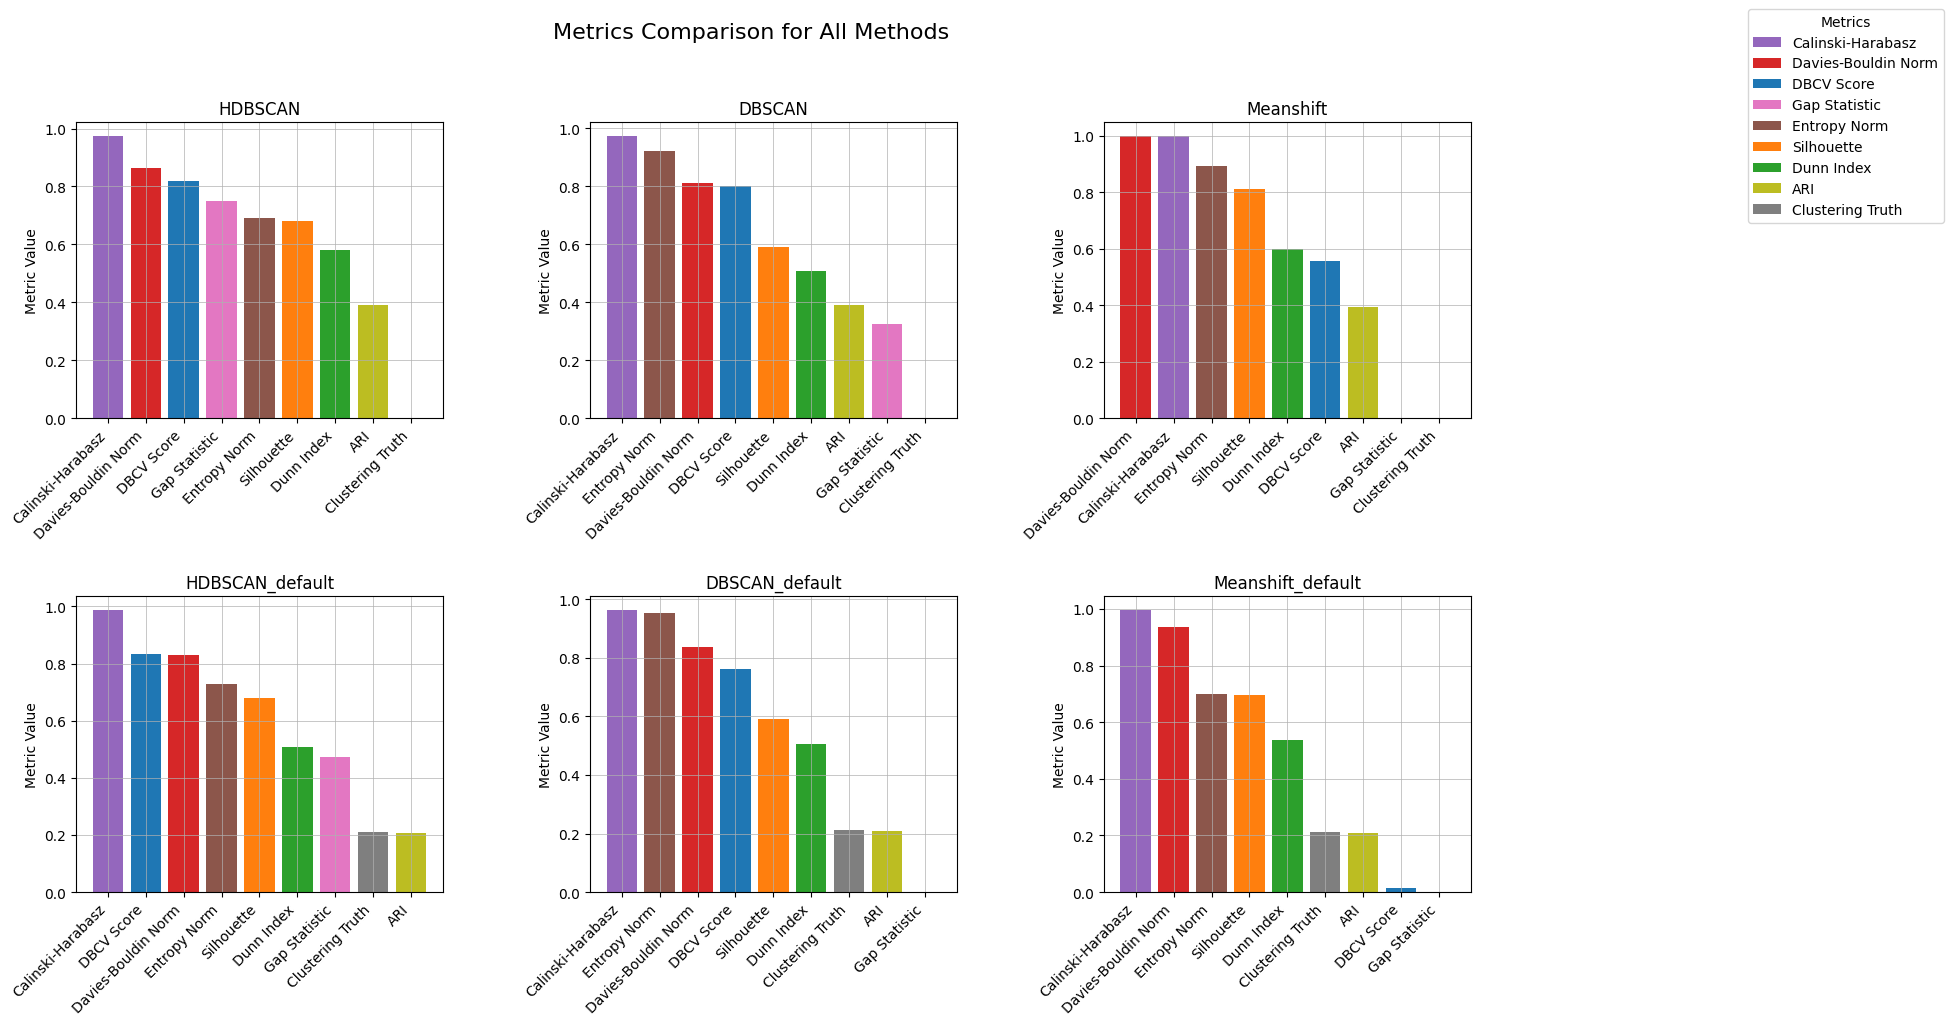

In [108]:
df_metrics_heart_failure.set_index("Method", inplace=True)

methods = df_metrics_heart_failure.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_heart_failure.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_heart_failure.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()


#**Cardiac Arrest**

In [173]:
cardiac_arrest = cardiac_arrest.fillna(0)
numerical_features = cardiac_arrest.columns
scaler_minmax = MinMaxScaler()
cardiac_arrest_scaled = cardiac_arrest.copy()
cardiac_arrest_scaled[numerical_features] = scaler_minmax.fit_transform(cardiac_arrest_scaled[numerical_features])
cardiac_arrest_scaled.reset_index(drop=True, inplace=True)
cardiac_arrest_scaled.drop_duplicates(inplace=True)
df_metrics_cardiac_arrest = pd.DataFrame()
cardiac_arrest_scaled

Exitus  sex_woman  Age_years  Endotracheal_intubation  Functional_status  \
0       1.0        0.0   0.340206                      1.0           1.000000   
1       1.0        1.0   0.402062                      1.0           1.000000   
2       1.0        0.0   0.505155                      1.0           1.000000   
3       0.0        0.0   0.505155                      1.0           1.000000   
4       1.0        0.0   0.515464                      1.0           1.000000   
..      ...        ...        ...                      ...                ...   
417     1.0        0.0   0.742268                      1.0           1.000000   
418     1.0        0.0   0.649485                      1.0           1.000000   
419     1.0        0.0   0.711340                      1.0           0.666667   
420     1.0        0.0   0.670103                      1.0           1.000000   
421     1.0        0.0   0.536082                      1.0           1.000000   

     Asystole  Cardiac_arrest_at_home  Bystander  Time_min  Cardiogenic  
0         1.0                     1.0        1.0  0.102041          1.0  
1         1.0                     1.0        1.0  0.204082          1.0  
2         0.0                     0.0        1.0  0.469388          0.0  
3         0.0                     1.0        1.0  0.142857          1.0  
4         0.0                     0.0        1.0  0.306122          1.0  
..        ...                     ...        ...       ...          ...  
417       0.0                     1.0        1.0  0.183673          1.0  
418       1.0                     1.0        1.0  0.387755          1.0  
419       1.0                     0.0        0.0  0.183673          1.0  
420       0.0                     1.0        0.0  0.306122          0.0  
421       1.0                     1.0        0.0  0.102041          0.0  

[420 rows x 10 columns]

**HDBSCAN**

In [174]:
min_size, epsilon= best_params_hdbscan(cardiac_arrest_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(cardiac_arrest_scaled)
labels_default = hdbscan_cluster_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels_default)
cardiac_arrest_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])

df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)


min_cluster_size: 3, cluster_selection_epsilon: 0.5


**DBSCAN**

In [175]:
min_sample, eps = best_params_dbscan(cardiac_arrest_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(cardiac_arrest_scaled)
labels_default = dbscan_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels_default)
cardiac_arrest_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

min_cluster_size: 3, cluster_selection_epsilon: 0.5


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0          HDBSCAN        0.72        0.47    0.034848                 0.81   
1  HDBSCAN_default        0.63        0.54    0.002012                 1.94   
2           DBSCAN        0.80        0.58    0.012136                 1.11   
3   DBSCAN_default        0.70        0.53    0.032706                 1.23   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              28.30          0.52          -0.02  
1             196.00          0.67          -0.56  
2             181.46          0.57          -0.87  
3              43.65          0.70          -2.32

**Mean_Shift**

In [176]:
band = best_params_mean_shift(cardiac_arrest_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(cardiac_arrest_scaled)
labels_default = mean_shift_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels_default)
cardiac_arrest_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

Banda 26.00532737517608 genera solo un cluster. Ignorato.
Best bandwidth: 10.595


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.72        0.47    0.034848                 0.81   
1    HDBSCAN_default        0.63        0.54    0.002012                 1.94   
2             DBSCAN        0.80        0.58    0.012136                 1.11   
3     DBSCAN_default        0.70        0.53    0.032706                 1.23   
4          Meanshift        0.14        0.64    0.299152                 1.89   
5  Meanshift_default       -0.90        0.49    0.093358                 1.35   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              28.30          0.52          -0.02  
1             196.00          0.67          -0.56  
2             181.46          0.57          -0.87  
3              43.65          0.70          -2.32  
4             805.04          0.32          -2.47  
5             331.08          0.27          -2.37

**Cluster Analysis**

In [177]:
cluster_similarity = similar_cluster(cardiac_arrest_scaled)
cluster_similarity

[4 7 1 0 2 3 6 5 8 9]
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 40 35 36 37 38 39 41]
[34 32 10 -1 22  2 30 25 26 21 27 23 33 11 13 20 14 19 17 35 29 15 31 28
 18  9  0  6  7 16  5 24 12  3  8  1  4]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
3296            1      -1       -1    14.523810
0               4       0       34     6.666667
7049            2      17       35     5.952381
5077            0       7       26     5.000000
4925            0       3       22     4.285714
...           ...     ...      ...          ...
5318            0      13        6     0.000000
5319            0      13        7     0.000000
5320            0      13       16     0.000000
5321            0      13        5     0.000000
15909           9      41        4     0.000000

[15910 rows x 4 columns]

In [178]:
cluster_similarity_default = similar_cluster_default(cardiac_arrest_scaled)
cluster_similarity_default

[0 1 2]
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]
[23 22  7 -1 12 18 14 15 11 13 17 24  3  4  9  8 25 21  6 19 20 10  1  2
  5  0 16]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
840            1      -1       -1    16.428571
1596           2      -1       -1    10.000000
0              0       0       23     6.666667
475            0      16       25     5.952381
196            0       6       15     5.000000
...          ...     ...      ...          ...
764            1       0       11     0.000000
763            1       0       15     0.000000
762            1       0       14     0.000000
761            1       0       18     0.000000
2267           2      26       16     0.000000

[2268 rows x 4 columns]

In [179]:
cardiac_arrest_scaled["DBSCAN_pred"] = cardiac_arrest_scaled["DBSCAN_pred"].astype(object)
cardiac_arrest_scaled["HDBSCAN_pred"] = cardiac_arrest_scaled["HDBSCAN_pred"].astype(object)
cardiac_arrest_scaled["Mean_shift_pred"] = cardiac_arrest_scaled["Mean_shift_pred"].astype(object)

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 34, "HDBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 17, "DBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 35, "HDBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 26, "HDBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'D'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 20, "HDBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'E'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 32, "DBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 24, "HDBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'F'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 22, "DBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 18, "HDBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'G'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 2, "DBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 10, "HDBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'H'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 39, "DBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'I'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == 0, "DBSCAN_default_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == 23, "HDBSCAN_default_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == 25, "DBSCAN_default_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == 0, "HDBSCAN_default_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,})
    .astype(int)
)

cardiac_arrest_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C':2})
    .astype(int)
)

same_value_count = (cardiac_arrest_scaled["HDBSCAN_pred"] == cardiac_arrest_scaled["DBSCAN_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_pred"] == cardiac_arrest_scaled["Mean_shift_pred"])

same_value_count_default = (cardiac_arrest_scaled["HDBSCAN_default_pred"] == cardiac_arrest_scaled["DBSCAN_default_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_default_pred"] == cardiac_arrest_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_deafult = same_value_count_default.sum()
total_rows = len(cardiac_arrest_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(cardiac_arrest_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(cardiac_arrest_scaled)

df_metrics_cardiac_arrest['Clustering Truth'] = df_metrics_cardiac_arrest['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_cardiac_arrest['ARI'] = df_metrics_cardiac_arrest['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_cardiac_arrest = df_metrics_cardiac_arrest.sort_values('DBCV Score', ascending=False)
df_metrics_cardiac_arrest

Totale delle righe con lo stesso valore: 183
Percentuale rispetto al totale: 43.57 %
Totale delle righe con lo stesso valore con parametri default: 115
Percentuale rispetto al totale: 27.38 %


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
2             DBSCAN        0.80        0.58    0.012136                 1.11   
0            HDBSCAN        0.72        0.47    0.034848                 0.81   
3     DBSCAN_default        0.70        0.53    0.032706                 1.23   
1    HDBSCAN_default        0.63        0.54    0.002012                 1.94   
4          Meanshift        0.14        0.64    0.299152                 1.89   
5  Meanshift_default       -0.90        0.49    0.093358                 1.35   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
2             181.46          0.57          -0.87             0.436  0.524488  
0              28.30          0.52          -0.02             0.436  0.524488  
3              43.65          0.70          -2.32             0.274  0.314027  
1             196.00          0.67          -0.56             0.274  0.314027  
4             805.04          0.32          -2.47             0.436  0.524488  
5             331.08          0.27          -2.37             0.274  0.314027

In [182]:
df_metrics_cardiac_arrest["Silhouette"] = (df_metrics_cardiac_arrest["Silhouette"] + 1) / 2
df_metrics_cardiac_arrest["DBCV Score"] = (df_metrics_cardiac_arrest["DBCV Score"] + 1) / 2
df_metrics_cardiac_arrest["Dunn Index"] = (erf(df_metrics_cardiac_arrest["Dunn Index"]) + 1) / 2
df_metrics_cardiac_arrest["Davies-Bouldin Norm"] = (erf(df_metrics_cardiac_arrest["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_cardiac_arrest["Calinski-Harabasz"] = 1 - (1 / df_metrics_cardiac_arrest["Calinski-Harabasz"])
df_metrics_cardiac_arrest["Entropy Norm"] = (erf(df_metrics_cardiac_arrest["Entropy Norm"]) + 1) / 2
df_metrics_cardiac_arrest["Gap Statistic"] = (erf(df_metrics_cardiac_arrest["Gap Statistic"]) + 1) / 2
df_metrics_cardiac_arrest

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
2             DBSCAN       0.900       0.790    0.506847             0.941767   
0            HDBSCAN       0.860       0.735    0.519653             0.874002   
3     DBSCAN_default       0.850       0.765    0.518446             0.959025   
1    HDBSCAN_default       0.815       0.770    0.501135             0.996961   
4          Meanshift       0.570       0.820    0.663876             0.996240   
5  Meanshift_default       0.050       0.745    0.552519             0.971881   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
2           0.994489      0.789908       0.109280             0.436  0.524488  
0           0.964664      0.768949       0.488718             0.436  0.524488  
3           0.977090      0.838901       0.000517             0.274  0.314027  
1           0.994898      0.828314       0.214192             0.274  0.314027  
4           0.998758      0.674563       0.000239             0.436  0.524488  
5           0.996980      0.648709       0.000402             0.274  0.314027

In [183]:
distance_table_cardiac_arrest = df_metrics_cardiac_arrest.copy()

for metric in metrics:
    distance_table_cardiac_arrest[metric] = np.sqrt((df_metrics_cardiac_arrest[metric] - df_metrics_cardiac_arrest["Clustering Truth"]) ** 2)
distance_table_cardiac_arrest = distance_table_cardiac_arrest.sort_values(by="DBCV Score", ascending=True)
distance_table_cardiac_arrest.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_cardiac_arrest.columns
]
distance_table_cardiac_arrest

Method  DBCV Score Distance  Silhouette Distance  \
4          Meanshift                0.134                0.384   
5  Meanshift_default                0.224                0.471   
0            HDBSCAN                0.424                0.299   
2             DBSCAN                0.464                0.354   
1    HDBSCAN_default                0.541                0.496   
3     DBSCAN_default                0.576                0.491   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
4             0.227876                      0.560240   
5             0.278519                      0.697881   
0             0.083653                      0.438002   
2             0.070847                      0.505767   
1             0.227135                      0.722961   
3             0.244446                      0.685025   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
4                    0.562758               0.238563                0.435761   
5                    0.722980               0.374709                0.273598   
0                    0.528664               0.332949                0.052718   
2                    0.558489               0.353908                0.326720   
1                    0.720898               0.554314                0.059808   
3                    0.703090               0.564901                0.273483   

   Clustering Truth       ARI  
4             0.436  0.524488  
5             0.274  0.314027  
0             0.436  0.524488  
2             0.436  0.524488  
1             0.274  0.314027  
3             0.274  0.314027

**No normalizzazione**

In [181]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_cardiac_arrest.columns:
            best_value = distance_table_cardiac_arrest.loc[distance_table_cardiac_arrest["Method"] == method, metric_value].values[0]
            default_value = distance_table_cardiac_arrest.loc[distance_table_cardiac_arrest["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_cardiac_arrest,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters     Default     Method trend  \
0                DBCV         0.364000    0.426000     DBSCAN     ↑   
1          Silhouette         0.144000    0.256000     DBSCAN     ↑   
2                Dunn         0.423864    0.241294     DBSCAN     ↓   
3      Davies-Bouldin         0.674000    0.956000     DBSCAN     ↑   
4   Calinski-Harabasz       181.024000   43.376000     DBSCAN     ↓   
5             Entropy         0.134000    0.426000     DBSCAN     ↑   
6                 Gap         1.306000    2.594000     DBSCAN     ↑   
7                DBCV         0.284000    0.356000    HDBSCAN     ↑   
8          Silhouette         0.034000    0.266000    HDBSCAN     ↑   
9                Dunn         0.401152    0.271988    HDBSCAN     ↓   
10     Davies-Bouldin         0.374000    1.666000    HDBSCAN     ↑   
11  Calinski-Harabasz        27.864000  195.726000    HDBSCAN     ↑   
12            Entropy         0.084000    0.396000    HDBSCAN     ↑   
13                Gap         0.456000    0.834000    HDBSCAN     ↑   
14               DBCV         0.296000    1.174000  Meanshift     ↑   
15         Silhouette         0.204000    0.216000  Meanshift     ↑   
16               Dunn         0.136848    0.180642  Meanshift     ↑   
17     Davies-Bouldin         1.454000    1.076000  Meanshift     ↓   
18  Calinski-Harabasz       804.604000  330.806000  Meanshift     ↓   
19            Entropy         0.116000    0.004000  Meanshift     ↓   
20                Gap         2.906000    2.644000  Meanshift     ↓   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                    Inconsistent  
3                      Consistent  
4                    Inconsistent  
5                      Consistent  
6                      Consistent  
7                      Consistent  
8                      Consistent  
9                    Inconsistent  
10                     Consistent  
11                     Consistent  
12                     Consistent  
13                     Consistent  
14                     Consistent  
15                     Consistent  
16                     Consistent  
17                   Inconsistent  
18                   Inconsistent  
19                   Inconsistent  
20                   Inconsistent

**Normalizzazione**

In [184]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_cardiac_arrest.columns:
            best_value = distance_table_cardiac_arrest.loc[distance_table_cardiac_arrest["Method"] == method, metric_value].values[0]
            default_value = distance_table_cardiac_arrest.loc[distance_table_cardiac_arrest["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_cardiac_arrest,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "trend consistency with reality": consistency
            })

final_table = pd.DataFrame(results)
final_table

Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.464000  0.576000     DBSCAN     ↑   
1          Silhouette         0.354000  0.491000     DBSCAN     ↑   
2                Dunn         0.070847  0.244446     DBSCAN     ↑   
3      Davies-Bouldin         0.505767  0.685025     DBSCAN     ↑   
4   Calinski-Harabasz         0.558489  0.703090     DBSCAN     ↑   
5             Entropy         0.353908  0.564901     DBSCAN     ↑   
6                 Gap         0.326720  0.273483     DBSCAN     ↓   
7                DBCV         0.424000  0.541000    HDBSCAN     ↑   
8          Silhouette         0.299000  0.496000    HDBSCAN     ↑   
9                Dunn         0.083653  0.227135    HDBSCAN     ↑   
10     Davies-Bouldin         0.438002  0.722961    HDBSCAN     ↑   
11  Calinski-Harabasz         0.528664  0.720898    HDBSCAN     ↑   
12            Entropy         0.332949  0.554314    HDBSCAN     ↑   
13                Gap         0.052718  0.059808    HDBSCAN     ↑   
14               DBCV         0.134000  0.224000  Meanshift     ↑   
15         Silhouette         0.384000  0.471000  Meanshift     ↑   
16               Dunn         0.227876  0.278519  Meanshift     ↑   
17     Davies-Bouldin         0.560240  0.697881  Meanshift     ↑   
18  Calinski-Harabasz         0.562758  0.722980  Meanshift     ↑   
19            Entropy         0.238563  0.374709  Meanshift     ↑   
20                Gap         0.435761  0.273598  Meanshift     ↓   

   trend consistency with reality  
0                      Consistent  
1                      Consistent  
2                      Consistent  
3                      Consistent  
4                      Consistent  
5                      Consistent  
6                    Inconsistent  
7                      Consistent  
8                      Consistent  
9                      Consistent  
10                     Consistent  
11                     Consistent  
12                     Consistent  
13                     Consistent  
14                     Consistent  
15                     Consistent  
16                     Consistent  
17                     Consistent  
18                     Consistent  
19                     Consistent  
20                   Inconsistent

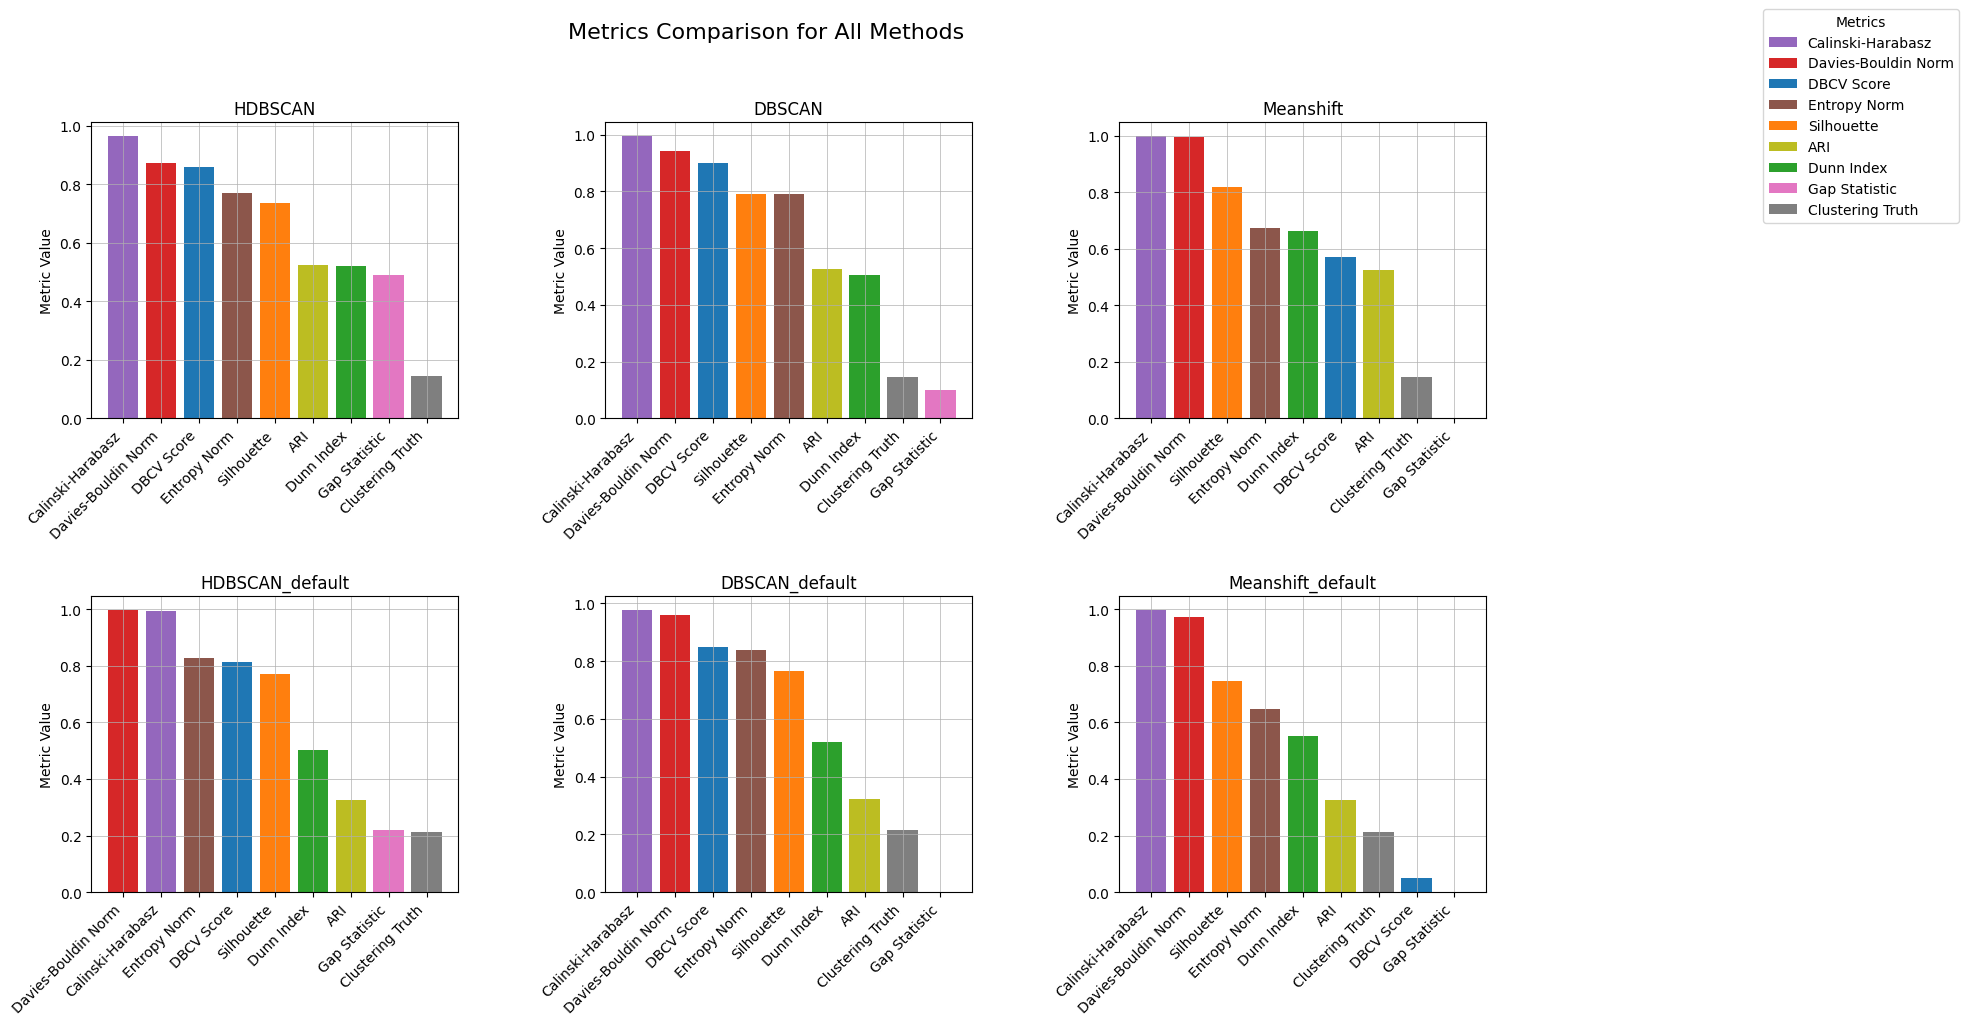

In [119]:
df_metrics_cardiac_arrest.set_index("Method", inplace=True)

methods = df_metrics_cardiac_arrest.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_cardiac_arrest.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_cardiac_arrest.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()
